# Clustering des trajectoires similaires

In [1]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes
nusc = NuScenes(version='v1.0-mini', dataroot='/Users/tiffanydarini/nuscenes-devkit/python-sdk/tutorials/data/sets/nuscenes/v1.0-mini', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.349 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


### Fonction utiles et imports nécessaires

In [2]:
# Fonction qui renvoie les tables ego_pose d'une scène donnée
def get_poses(scene_token):
    pose_list = []
    scene_rec = nusc.get('scene', scene_token)
    sample_rec = nusc.get('sample', scene_rec['first_sample_token'])
    sd_rec = nusc.get('sample_data', sample_rec['data']['LIDAR_TOP'])
    
    ego_pose = nusc.get('ego_pose', sd_rec['token'])
    pose_list.append(ego_pose)

    while sd_rec['next'] != '':
        sd_rec = nusc.get('sample_data', sd_rec['next'])
        ego_pose = nusc.get('ego_pose', sd_rec['token'])
        pose_list.append(ego_pose)

    return pose_list

In [3]:
# On crée une fonction qui renvoie la liste des rangs dans les listes X,Y des objets immobiles de 
# cette liste et donc d'une même catégorie, ainsi que la liste des objets mobiles 
from math import sqrt

def immobile(X,Y):
    Immo = []
    Mobile = []
    n = len(X) # Nombre d'élément dans la catégorie 
    for i in range(0,n-1):
        X_coord = X[i]
        Y_coord = Y[i]
        if len(X_coord)==1 :
            Immo.append(i)
        else : 
            d = 0 
            for k in range(0,len(X_coord)-1):
                d+= sqrt((X_coord[k+1]-X_coord[k])**2+(Y_coord[k+1]-Y_coord[k])**2)
            if d<2 : # Si la distance totale parcourue par l'objet est inférieur à 2m, on considère que l'objet bouge pas
                Immo.append(i)
            else :
                Mobile.append(i)
    return Immo,Mobile  

In [4]:
from dtw import *
import matplotlib.pyplot as plt
from datetime import timedelta

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [5]:
import numpy as np 
from math import sqrt 

# Fonction qui renvoie la matrice des distances 
def Matrice_distance(X_ego,Y_ego,X_veh,Y_veh):
    M = np.zeros((len(X_veh),len(X_ego)))
    for i in range(0,len(X_veh)):
        for j in range(0,len(X_ego)):
            #M[i,j] = sqrt((X_veh[len(X_veh)-1-i]-X_ego[j])**2+(Y_veh[len(Y_veh)-1-i]-Y_ego[j])**2)
            M[i,j] = sqrt((X_veh[i]-X_ego[j])**2+(Y_veh[i]-Y_ego[j])**2)
    return M 
     

In [6]:
import numpy as np 
from math import sqrt 

# Fonction qui renvoie la matrice des distances entre 
# les pts qui interagissent dans le temps 

def M_distance_time(X_ego,Y_ego,T_ego,X_veh,Y_veh,T_veh):
    
    debut = max(T_ego[0],T_veh[0]) # Temps début detection vehicule 1 
    fin = min(T_ego[len(T_ego)-1],T_veh[len(T_veh)-1]) # Temps fin detection vehicule 1 

    # On va créer la liste des indices des élements du veh 1 qui sont en même temps que le veh 2
    L_indice_ego = []
    for k in range(0,len(T_ego)):
        if debut<=T_ego[k]<=fin:
            L_indice_ego.append(k)
            
    # Pareil pour le veh 
    L_indice_veh = []
    for k in range(0,len(T_veh)):
        if debut<=T_veh[k]<=fin:
            L_indice_veh.append(k)
    
    M = np.zeros((len(L_indice_veh),len(L_indice_ego)))
    for i in range(0,len(L_indice_veh)):
        for j in range(0,len(L_indice_ego)):
            M[i,j] = sqrt((X_veh[L_indice_veh[i]]-X_ego[L_indice_ego[j]])**2+(Y_veh[L_indice_veh[i]]-Y_ego[L_indice_ego[j]])**2)
    
    return M 

In [7]:
# Pour normaliser le calcul de DTW, on va créer une fonction qui calcule
# la distance parcourue par un véhicule au cours de la scène, en prenant
# en entrée ses coordonnées

def distance_parcourue(X,Y,Z):
    D =[0]
    for k in range(0,len(X)-1):
        d = D[k]+ sqrt((X[k+1]-X[k])**2+(Y[k+1]-Y[k])**2+(Z[k+1]-Z[k])**2)
        D.append(d)
    return D[len(D)-1]

#### Fenêtre glissante

In [8]:
## Fonction qui renvoie une dataframe avec les valeurs de dtw calculés sur des intervalles de temps d'une seconde : 

#imports nécessaires
import matplotlib.pyplot as plt
from math import sqrt
import datetime 
from datetime import timedelta
from dtw import *
import pandas as pd

def dtw_glissante(scene_name):
    
    # On crée une dataframe 
    df = pd.DataFrame()
    L_intervalle = [[k,k+1] for k in range(0,20)]
    df['index']= L_intervalle
    df.set_index('index',inplace=True)
    df.index.name = None
    
    scene_token = nusc.field2token('scene','name',scene_name)[0]
    sample_token = nusc.field2token('sample','scene_token',scene_token)# Ensemble des token des échantillons de la scene 
    
    # Pour tracer la trajectoire du véhicule ego
    Liste_ego_poses = get_poses(scene_token) 
    X_coord =[]
    Y_coord =[]
    Z_coord =[]
    T_timestamp = [] # liste des timestamps
    for k in range(0,len(Liste_ego_poses)):
        X_coord.append(Liste_ego_poses[k]['translation'][0])
        Y_coord.append(Liste_ego_poses[k]['translation'][1])
        Z_coord.append(Liste_ego_poses[k]['translation'][2])
        T_timestamp.append(Liste_ego_poses[k]['timestamp'])
        
    # Ensemble des sample_annotation de la scène :
    sample_annotation_token = []
    for k in sample_token : 
        L = nusc.field2token('sample_annotation','sample_token',k)
        sample_annotation_token = sample_annotation_token + L
    
    # On créé la liste des token des instances présents dans les sample_annotation
    L_instance_token = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_instance_token.append(exemple['instance_token'])
    # Puisque pour un même objet, on peut avoir plusieurs annotations, on supprime les doublons de L
    L_instance_token = list(set(L_instance_token))
    
    # Liste des catégories d'objet dans la scène 
    L_category_name = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_category_name.append(exemple['category_name'])
    L_category_name = list(set(L_category_name)) #on supprime les doublons 
   
    L_vehicule = ['vehicle.bicycle','vehicle.bus.bendy','vehicle.bus.rigid','vehicle.car','vehicle.construction','vehicle.emergency.ambulance','vehicle.emergency.police','vehicle.motorcycle','vehicle.trailer','vehicle.truck']
    
    L_category_name = [k for k in L_category_name if k in L_vehicule]
    
    # Boucle sur chaque catégorie trouvée
    for j in range(0,len(L_category_name)):   
        catego_name = L_category_name[j]
        catego_token = nusc.field2token('category','name',catego_name)
        category = nusc.get('category',catego_token[0])

        # Ensemble des instances appartenant à la fois à la scène et à la catégorie
        L_instance_category = nusc.field2token('instance','category_token',catego_token[0]) # instance dans la catégorie
        L_instance_category = [x for x in L_instance_category if x in L_instance_token]# et dans la scène 
        L_instance_category
        
        # Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
        # les token des sample_annotation pour un élément de cette catégorie. 

        L=[]
        for k in L_instance_category : 
            instance_category = nusc.get('instance',k)
            nbr_annotations = instance_category['nbr_annotations']
            if nbr_annotations == 1:
                L.append([instance_category['first_annotation_token']])
            else : 
                H = []
                first_token = instance_category['first_annotation_token']
                last_token = instance_category['last_annotation_token']
                current_token = first_token 
        
                s = 0 
                while s!= nbr_annotations :
                    current_ann = nusc.get('sample_annotation', current_token)
                    H.append(current_ann['token'])
                    current_token = current_ann['next'] #On passe au suivant
                    s+=1
                L.append(H)
        
        # Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
        # on va pouvoir récupérer leurs positions et tracer leurs trajectoires

        X = []
        Y = []
        Z = []
        T_time = []
        for k in L :
            x = []
            y = []
            z = []
            t=[]
            for j in k :
                sample_annotation = nusc.get('sample_annotation',j)
                x.append(sample_annotation['translation'][0])
                y.append(sample_annotation['translation'][1])
                z.append(sample_annotation['translation'][2])
                t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
            X.append(x)
            Y.append(y)
            Z.append(z)
            T_time.append(t)
    
        # On crée les listes des objets immobiles et mobiles de la catégorie
        Immo, Mobile = immobile(X,Y)
        
        # On conserve uniquement les objets mobiles 
        X_mobile=[X[i] for i in Mobile]
        Y_mobile=[Y[i] for i in Mobile]
        Z_mobile=[Z[i] for i in Mobile]
        T_mobile = [T_time[i] for i in Mobile]
        
        if len(X_mobile)>0:
        
            for i in range(0,len(X_mobile)):
            
                L_df = []
                # On fait une boucle sur les intervalles de temps 
                for k in range(0,20):
                    current_intervalle = [k,k+1]
                    # On crée les listes des coordonnées qu'on va garder ie qui sont dans l'intervalle de temps ci-dessus
                    Lx_pt_veh = []
                    Ly_pt_veh = []
                    Lt_pt_veh = []
                    Lx_pt_ego = []
                    Ly_pt_ego = []
                    Lt_pt_ego = []
                
                    # On remplit avec les pts du véhicule dont le timestamp est dans l'intervalle 
                    for s in range(len(X_mobile[i])):
                        tveh = (datetime.datetime.fromtimestamp(T_mobile[i][s]/1e6)-datetime.datetime.fromtimestamp(T_timestamp[0]/ 1e6)).total_seconds()
                        if tveh <= current_intervalle[1] and tveh >= current_intervalle[0] :
                            Lx_pt_veh.append(X_mobile[i][s])
                            Ly_pt_veh.append(Y_mobile[i][s])
                            Lt_pt_veh.append(T_mobile[i][s])
                    
                
                
                    # On remplit avec les pts du véhicule ego dont le timestamp est dans l'intervalle 
                    for s in range(len(X_coord)):
                        tego = (datetime.datetime.fromtimestamp(T_timestamp[s]/1e6)-datetime.datetime.fromtimestamp(T_timestamp[0]/ 1e6)).total_seconds()
                        if tego <= current_intervalle[1] and tego >= current_intervalle[0]:
                            Lx_pt_ego.append(X_coord[s])
                            Ly_pt_ego.append(Y_coord[s])
                            Lt_pt_ego.append(T_timestamp[s])
                
                            
                    if len(Lx_pt_veh)==0:
                        L_df.append(np.nan)
                    else :
                        #M_distance = M_distance_time(Lx_pt_ego,Ly_pt_ego,Lt_pt_ego,Lx_pt_veh,Ly_pt_veh,Lt_pt_veh)
                        M_distance = Matrice_distance(Lx_pt_ego,Ly_pt_ego,Lx_pt_veh,Ly_pt_veh)
                        alignment = dtw(M_distance)
                        distance = alignment.normalizedDistance
                        L_df.append(distance) 


                nom = catego_name +' '+str(i+1)
                df[nom]= L_df
    
    return df

#M_distance_time(X_coord,Y_coord,T_timestamp,X_mobile[i],Y_mobile[i],T_mobile[i])

#### Produit scalaire entre les vecteurs

In [9]:
# Fonction qui renvoie la matrice des produits scalaires
import numpy as np

def Matrice_produit_scalaire(X_coord,Y_coord,T_timestamp,X_veh,Y_veh,T_veh):
    
        
    debut = max(T_timestamp[0],T_veh[0]) # Temps début detection vehicule 1 
    fin = min(T_timestamp[len(T_timestamp)-1],T_veh[len(T_veh)-1]) # Temps fin detection vehicule 1 

    # On va créer la liste des indices des élements du veh 1 qui sont en même temps que le veh 2
    L_indice_ego = []
    for k in range(0,len(T_timestamp)):
        if debut<=T_timestamp[k]<=fin:
            L_indice_ego.append(k)
            
    # Pareil pour le veh 
    L_indice_veh = []
    for k in range(0,len(T_veh)):
        if debut<=T_veh[k]<=fin:
            L_indice_veh.append(k)
    
    # On crée la liste des vecteurs pour le véhicule ego avec les points qu'on peut garder
    V_ego = []
    for k in range(0,len(L_indice_ego)-1):
        t2 = datetime.datetime.fromtimestamp(T_timestamp[L_indice_ego[k+1]]/ 1e6)
        t1 = datetime.datetime.fromtimestamp(T_timestamp[L_indice_ego[k]]/ 1e6)
        t = (t2-t1).total_seconds()
        v = np.array([X_coord[L_indice_ego[k+1]]-X_coord[L_indice_ego[k]],Y_coord[L_indice_ego[k+1]]-Y_coord[L_indice_ego[k]]])/t # Le vecteur a pour norme la vitesse à l'instant k
        V_ego.append(v)
        
        
    # On crée la liste des vecteurs pour le veh avec les points qu'on peut garder
    V = []
    for k in range(0,len(L_indice_veh)-1):
        t2 = datetime.datetime.fromtimestamp(T_veh[L_indice_veh[k+1]]/ 1e6)
        t1 = datetime.datetime.fromtimestamp(T_veh[L_indice_veh[k]]/ 1e6)
        t = (t2-t1).total_seconds()
        v = np.array([X_veh[L_indice_veh[k+1]]-X_veh[L_indice_veh[k]],Y_veh[L_indice_veh[k+1]]-Y_veh[L_indice_veh[k]]])/t
        V.append(v)
        
    # On crée la matrice des produits scalaires : 
    M = np.zeros((len(V),len(V_ego)))
    for i in range(0,len(V)):
        for j in range(0,len(V_ego)):
            M[i,j] = np.dot(V[i],V_ego[j])/(np.linalg.norm(V[i])*np.linalg.norm(V_ego[j]))
    return M 

In [10]:
# Fonction qui renvoie la norme du produit vectoriel divisée par la norme des vecteurs

def Matrice_produit_vectoriel(X_coord,Y_coord,T_timestamp,X_veh,Y_veh,T_veh):
    
         
    debut = max(T_timestamp[0],T_veh[0]) # Temps début detection vehicule 1 
    fin = min(T_timestamp[len(T_timestamp)-1],T_veh[len(T_veh)-1]) # Temps fin detection vehicule 1 

    # On va créer la liste des indices des élements du veh 1 qui sont en même temps que le veh 2
    L_indice_ego = []
    for k in range(0,len(T_timestamp)):
        if debut<=T_timestamp[k]<=fin:
            L_indice_ego.append(k)
            
    # Pareil pour le veh 
    L_indice_veh = []
    for k in range(0,len(T_veh)):
        if debut<=T_veh[k]<=fin:
            L_indice_veh.append(k)
    
    # On crée la liste des vecteurs pour le véhicule ego avec les points qu'on peut garder
    V_ego = []
    for k in range(0,len(L_indice_ego)-1):
        t2 = datetime.datetime.fromtimestamp(T_timestamp[L_indice_ego[k+1]]/ 1e6)
        t1 = datetime.datetime.fromtimestamp(T_timestamp[L_indice_ego[k]]/ 1e6)
        t = (t2-t1).total_seconds()
        v = np.array([X_coord[L_indice_ego[k+1]]-X_coord[L_indice_ego[k]],Y_coord[L_indice_ego[k+1]]-Y_coord[L_indice_ego[k]]])/t # Le vecteur a pour norme la vitesse à l'instant k
        V_ego.append(v)
        
        
    # On crée la liste des vecteurs pour le veh avec les points qu'on peut garder
    V = []
    for k in range(0,len(L_indice_veh)-1):
        t2 = datetime.datetime.fromtimestamp(T_veh[L_indice_veh[k+1]]/ 1e6)
        t1 = datetime.datetime.fromtimestamp(T_veh[L_indice_veh[k]]/ 1e6)
        t = (t2-t1).total_seconds()
        v = np.array([X_veh[L_indice_veh[k+1]]-X_veh[L_indice_veh[k]],Y_veh[L_indice_veh[k+1]]-Y_veh[L_indice_veh[k]]])/t
        V.append(v)

    # On crée la matrice des produits scalaires : 
    M = np.zeros((len(V),len(V_ego)))
    for i in range(0,len(V)):
        for j in range(0,len(V_ego)):
            M[i,j] = np.linalg.norm(np.cross(V[i],V_ego[j]))/(np.linalg.norm(V[i])*np.linalg.norm(V_ego[j]))
    return M 

In [11]:
# Fonction qui renvoie la vitesse moyenne de deux véhicules pendant le temps où ils interagissent 

def vitesse_moyenne(X_coord,Y_coord,T_timestamp,X_veh,Y_veh,T_veh):
    
    debut = max(T_timestamp[0],T_veh[0]) # Temps début detection vehicule 1 
    fin = min(T_timestamp[len(T_timestamp)-1],T_veh[len(T_veh)-1]) # Temps fin detection vehicule 1 

    # On va créer la liste des indices des élements du veh 1 qui sont en même temps que le veh 2
    L_indice_ego = []
    for k in range(0,len(T_timestamp)):
        if debut<=T_timestamp[k]<=fin:
            L_indice_ego.append(k)
            
    # Pareil pour le veh 
    L_indice_veh = []
    for k in range(0,len(T_veh)):
        if debut<=T_veh[k]<=fin:
            L_indice_veh.append(k)
    
    # On crée la liste des vecteurs pour le véhicule ego avec les points qu'on peut garder
    V_ego = []
    for k in range(0,len(L_indice_ego)-1):
        t2 = datetime.datetime.fromtimestamp(T_timestamp[L_indice_ego[k+1]]/ 1e6)
        t1 = datetime.datetime.fromtimestamp(T_timestamp[L_indice_ego[k]]/ 1e6)
        t = (t2-t1).total_seconds()
        v = np.array([X_coord[L_indice_ego[k+1]]-X_coord[L_indice_ego[k]],Y_coord[L_indice_ego[k+1]]-Y_coord[L_indice_ego[k]]])/t # Le vecteur a pour norme la vitesse à l'instant k
        V_ego.append(v)
    # Il faut créer le vecteur des normes de V_ego qui contient lui que des vecteurs 
    v_ego_moy = np.mean([np.linalg.norm(V_ego[i]) for i in range(0,len(V_ego))])
        
    # On crée la liste des vecteurs pour le veh avec les points qu'on peut garder
    V = []
    for k in range(0,len(L_indice_veh)-1):
        t2 = datetime.datetime.fromtimestamp(T_veh[L_indice_veh[k+1]]/ 1e6)
        t1 = datetime.datetime.fromtimestamp(T_veh[L_indice_veh[k]]/ 1e6)
        t = (t2-t1).total_seconds()
        v = np.array([X_veh[L_indice_veh[k+1]]-X_veh[L_indice_veh[k]],Y_veh[L_indice_veh[k+1]]-Y_veh[L_indice_veh[k]]])/t
        V.append(v)
    v_veh_moy = np.mean([np.linalg.norm(V[i]) for i in range(0,len(V))])
        
    return v_ego_moy,v_veh_moy

### Création des dataframes contenant les indicateurs 

In [12]:
#imports nécessaires
import matplotlib.pyplot as plt
from math import sqrt
import datetime 
from datetime import timedelta
from dtw import *
import pandas as pd
from statistics import mean

def indicateur_similarite(scene_name):
    
    # On crée une dataframe vide 
    df = pd.DataFrame()
    # Ligne de la dataframe 
    L_ligne = ['scene','Catégorie Véhicule 1','Numéro Véhicule 1','Catégorie Véhicule 2',\
               'Numéro Véhicule 2','Vitesse moyenne veh 1','Vitesse moyenne veh 2',\
               "Durée d'interaction",'DTW normalisée','Distance instantannée moyenne',\
               'Distance instantannée minimale','Distance instantannée maximale','TimeLag moyen horizontal',\
               'TimeLag moyen vertical',"Indicateur d'orthogonalité moyen","Indicateur d'orthogonalité min",\
               "Indicateur d'orthogonalité max",'Indicateur de colinéarité moyen',\
               'Indicateur de colinéarité min','Indicateur de colinéarité max','Sens',\
               'Distance minimale dans matrice distance','Distance maximale dans matrice distance',\
               'Distance moyenne dans matrice distance']
    # Les lignes en plus : 'Time log moyen'
    # On met ça en index 
    df['index']= L_ligne
    df.set_index('index',inplace=True)
    df.index.name = None
    
    # Dataframe des fenêtre glissantes 
    df_glissante = dtw_glissante(scene_name) 
    
    scene_token = nusc.field2token('scene','name',scene_name)[0]
    sample_token = nusc.field2token('sample','scene_token',scene_token)# Ensemble des token des échantillons de la scene 
    
    # Pour tracer la trajectoire du véhicule ego
    Liste_ego_poses = get_poses(scene_token) 
    X_coord =[]
    Y_coord =[]
    Z_coord =[]
    T_timestamp = [] # liste des timestamps
    for k in range(0,len(Liste_ego_poses)):
        X_coord.append(Liste_ego_poses[k]['translation'][0])
        Y_coord.append(Liste_ego_poses[k]['translation'][1])
        Z_coord.append(Liste_ego_poses[k]['translation'][2])
        T_timestamp.append(Liste_ego_poses[k]['timestamp'])
        
    # Ensemble des sample_annotation de la scène :
    sample_annotation_token = []
    for k in sample_token : 
        L = nusc.field2token('sample_annotation','sample_token',k)
        sample_annotation_token = sample_annotation_token + L
    
    # On créé la liste des token des instances présents dans les sample_annotation
    L_instance_token = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_instance_token.append(exemple['instance_token'])
    # Puisque pour un même objet, on peut avoir plusieurs annotations, on supprime les doublons de L
    L_instance_token = list(set(L_instance_token))
    
    # Liste des catégories d'objet dans la scène 
    L_category_name = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_category_name.append(exemple['category_name'])
    L_category_name = list(set(L_category_name)) #on supprime les doublons 
   
    L_vehicule = ['vehicle.bicycle','vehicle.bus.bendy','vehicle.bus.rigid','vehicle.car','vehicle.construction','vehicle.emergency.ambulance','vehicle.emergency.police','vehicle.motorcycle','vehicle.trailer','vehicle.truck']
    
    L_category_name = [k for k in L_category_name if k in L_vehicule]
    
    # Boucle sur chaque catégorie trouvée
    for j in range(0,len(L_category_name)):   
        catego_name = L_category_name[j]
        catego_token = nusc.field2token('category','name',catego_name)
        category = nusc.get('category',catego_token[0])

        # Ensemble des instances appartenant à la fois à la scène et à la catégorie
        L_instance_category = nusc.field2token('instance','category_token',catego_token[0]) # instance dans la catégorie
        L_instance_category = [x for x in L_instance_category if x in L_instance_token]# et dans la scène 
        L_instance_category
        
        # Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
        # les token des sample_annotation pour un élément de cette catégorie. 

        L=[]
        for k in L_instance_category : 
            instance_category = nusc.get('instance',k)
            nbr_annotations = instance_category['nbr_annotations']
            if nbr_annotations == 1:
                L.append([instance_category['first_annotation_token']])
            else : 
                H = []
                first_token = instance_category['first_annotation_token']
                last_token = instance_category['last_annotation_token']
                current_token = first_token 
        
                s = 0 
                while s!= nbr_annotations :
                    current_ann = nusc.get('sample_annotation', current_token)
                    H.append(current_ann['token'])
                    current_token = current_ann['next'] #On passe au suivant
                    s+=1
                L.append(H)
        
        # Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
        # on va pouvoir récupérer leurs positions et tracer leurs trajectoires

        X = []
        Y = []
        Z = []
        T_time = []
        for k in L :
            x = []
            y = []
            z = []
            t=[]
            for j in k :
                sample_annotation = nusc.get('sample_annotation',j)
                x.append(sample_annotation['translation'][0])
                y.append(sample_annotation['translation'][1])
                z.append(sample_annotation['translation'][2])
                t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
            X.append(x)
            Y.append(y)
            Z.append(z)
            T_time.append(t)
    
        # On crée les listes des objets immobiles et mobiles de la catégorie
        Immo, Mobile = immobile(X,Y)
        
        # On conserve uniquement les objets mobiles 
        X_mobile=[X[i] for i in Mobile]
        Y_mobile=[Y[i] for i in Mobile]
        Z_mobile=[Z[i] for i in Mobile]
        T_mobile = [T_time[i] for i in Mobile]
        
        for i in range(0,len(X_mobile)):
            L_objet = [] 
            # nom du véhicule 
            nom = catego_name +' '+str(i+1)
            
            ## Scene 
            L_objet.append(scene_name)
            
            ## Catégorie Véhicule 1
            L_objet.append('vehicle.ego')
            
            ## Numéro véhicule 1
            L_objet.append(1)
        
            ## Catégoie Véhicule 2
            L_objet.append(catego_name)
            
            ## Catégoie Véhicule 2
            L_objet.append(i+1)
            
            ## Vitesses moyennes 
            v_moy_ego, v_moy_veh = vitesse_moyenne(X_coord,Y_coord,T_timestamp,X_mobile[i],Y_mobile[i],T_mobile[i])
            L_objet.append(v_moy_ego)
            L_objet.append(v_moy_veh)
            
            ## Durée d'interaction 
            debut = max(T_mobile[i][0],T_timestamp[0])
            fin = min(T_mobile[i][-1],T_timestamp[-1])
            temps_ego = (datetime.datetime.fromtimestamp(T_timestamp[-1]/1e6)-datetime.datetime.fromtimestamp(T_timestamp[0]/ 1e6)).total_seconds()
            t_total = (datetime.datetime.fromtimestamp(fin/1e6)-datetime.datetime.fromtimestamp(debut/ 1e6)).total_seconds()
            L_objet.append(t_total/temps_ego)
            #L_objet.append(t_total)
            
            ## DTW normalisée
            #M_distance = Matrice_distance(X_coord,Y_coord,X_mobile[i],Y_mobile[i])
            M_distance = M_distance_time(X_coord,Y_coord,T_timestamp,X_mobile[i],Y_mobile[i],T_mobile[i])
            alignment = dtw(M_distance)
            distance = alignment.normalizedDistance
            L_objet.append(distance)
            
            Chemin = [[alignment.index1[k],alignment.index2[k]] for k in range(0,len(alignment.index1))]
            
            ## Distance instannée moyenne 
            L_objet.append(df_glissante[nom].mean())
            
            ## Distance instannée minimale
            L_objet.append(df_glissante[nom].min())
            
            ## Distance instannée maximale
            L_objet.append(df_glissante[nom].max())
            
            ## Time log moyen horizontal
            recurrence_0 = list(alignment.index1).count(0)
            indice_max_ego = alignment.index2[recurrence_0-1]
            t_horizontal = (datetime.datetime.fromtimestamp(T_timestamp[indice_max_ego]/1e6)-datetime.datetime.fromtimestamp(T_timestamp[0]/ 1e6)).total_seconds()
            L_objet.append(t_horizontal)
            
            ## Time log moyen vertical
            N = max(alignment.index2)
            recurrence_N = list(alignment.index2).count(N)
            indice_min_veh = alignment.index1[len(alignment.index1)-recurrence_N]
            t_vertical = (datetime.datetime.fromtimestamp(T_mobile[i][max(alignment.index1)]/1e6)-datetime.datetime.fromtimestamp(T_mobile[i][indice_min_veh]/ 1e6)).total_seconds()
            L_objet.append(t_vertical)
            
            ## Indicateur d'orthogonalité moyen : sin 
            M_pv = Matrice_produit_vectoriel(X_coord,Y_coord,T_timestamp,X_mobile[i],Y_mobile[i],T_mobile[i])
            L_pv = [M_pv[i,j] for(i,j) in Chemin[:len(Chemin)] if i<max(alignment.index1) and j<max(alignment.index2)]
            L_objet.append(mean(L_pv))
            
            ## Indicateur d'orthogonalité min 
            L_objet.append(min(L_pv))
            
            ## Indicateur d'orthogonalité max
            L_objet.append(max(L_pv))
            
            ## Indicateur de colinéarité moyen : cos
            M_ps = Matrice_produit_scalaire(X_coord,Y_coord,T_timestamp,X_mobile[i],Y_mobile[i],T_mobile[i])
            L_ps = [M_ps[i,j] for(i,j) in Chemin[:len(Chemin)] if i<max(alignment.index1) and j<max(alignment.index2)]
            L_objet.append(mean(L_ps))
            
            ## Indicateur de colinéarité min
            L_objet.append(min(L_ps))
            
            ## Indicateur de colinéarité max
            L_objet.append(max(L_ps))
            
            ## Sens 
            if mean(L_ps)>0:
                L_objet.append(1)
            else :
                L_objet.append(0)

            ## Distance min dans la matrice 
            L_objet.append(M_distance.min())
            
            ## Distance max dans la matrice 
            L_objet.append(M_distance.max()) 
            
            ## Distance moyenne dans la matrice 
            L_objet.append(M_distance.mean()) 
            
            nom = catego_name +' '+str(i+1)+'/ego dans '+scene_name
            df[nom]=L_objet
    return df.transpose()
    

#### On étend le calcul à une l'étude des interractions entre les véhicules 

In [13]:
#imports nécessaires
import matplotlib.pyplot as plt
from math import sqrt
import datetime 
from datetime import timedelta
from dtw import *
import pandas as pd
from statistics import mean

def indicateur_similarite_entre_veh(scene_name):
    
    # On crée une dataframe vide 
    df = pd.DataFrame()
    # Ligne de la dataframe 
    
    L_ligne = ['scene','Catégorie Véhicule 1','Numéro Véhicule 1','Catégorie Véhicule 2',\
               'Numéro Véhicule 2','Vitesse moyenne veh 1','Vitesse moyenne veh 2',\
               "Durée d'interaction",'DTW normalisée','Distance instantannée moyenne',\
               'Distance instantannée minimale','Distance instantannée maximale','TimeLag moyen horizontal',\
               'TimeLag moyen vertical',"Indicateur d'orthogonalité moyen","Indicateur d'orthogonalité min",\
               "Indicateur d'orthogonalité max",'Indicateur de colinéarité moyen',\
               'Indicateur de colinéarité min','Indicateur de colinéarité max','Sens',\
               'Distance minimale dans matrice distance','Distance maximale dans matrice distance',\
               'Distance moyenne dans matrice distance']
   
    # On met ça en index 
    df['index']= L_ligne
    df.set_index('index',inplace=True)
    df.index.name = None 

    scene_token = nusc.field2token('scene','name',scene_name)[0]
    sample_token = nusc.field2token('sample','scene_token',scene_token)# Ensemble des token des échantillons de la scene 
    
    # Pour tracer la trajectoire du véhicule ego
    Liste_ego_poses = get_poses(scene_token) 
    X_coord =[]
    Y_coord =[]
    Z_coord =[]
    T_timestamp = [] # liste des timestamps
    for k in range(0,len(Liste_ego_poses)):
        X_coord.append(Liste_ego_poses[k]['translation'][0])
        Y_coord.append(Liste_ego_poses[k]['translation'][1])
        Z_coord.append(Liste_ego_poses[k]['translation'][2])
        T_timestamp.append(Liste_ego_poses[k]['timestamp'])
        
    # Ensemble des sample_annotation de la scène :
    sample_annotation_token = []
    for k in sample_token : 
        L = nusc.field2token('sample_annotation','sample_token',k)
        sample_annotation_token = sample_annotation_token + L
    
    # On créé la liste des token des instances présents dans les sample_annotation
    L_instance_token = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_instance_token.append(exemple['instance_token'])
    # Puisque pour un même objet, on peut avoir plusieurs annotations, on supprime les doublons de L
    L_instance_token = list(set(L_instance_token))
    
    # Liste des catégories d'objet dans la scène 
    L_category_name = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_category_name.append(exemple['category_name'])
    L_category_name = list(set(L_category_name)) #on supprime les doublons 
   
    L_vehicule = ['vehicle.bicycle','vehicle.bus.bendy','vehicle.bus.rigid','vehicle.car','vehicle.construction','vehicle.emergency.ambulance','vehicle.emergency.police','vehicle.motorcycle','vehicle.trailer','vehicle.truck']
    
    L_category_name = [k for k in L_category_name if k in L_vehicule]
    
    # Boucle sur chaque catégorie trouvée
    for j in range(0,len(L_category_name)):   
        catego_name = L_category_name[j]
        catego_token = nusc.field2token('category','name',catego_name)
        category = nusc.get('category',catego_token[0])

        # Ensemble des instances appartenant à la fois à la scène et à la catégorie
        L_instance_category = nusc.field2token('instance','category_token',catego_token[0]) # instance dans la catégorie
        L_instance_category = [x for x in L_instance_category if x in L_instance_token]# et dans la scène 
        L_instance_category
        
        # Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
        # les token des sample_annotation pour un élément de cette catégorie. 

        L=[]
        for k in L_instance_category : 
            instance_category = nusc.get('instance',k)
            nbr_annotations = instance_category['nbr_annotations']
            if nbr_annotations == 1:
                L.append([instance_category['first_annotation_token']])
            else : 
                H = []
                first_token = instance_category['first_annotation_token']
                last_token = instance_category['last_annotation_token']
                current_token = first_token 
        
                s = 0 
                while s!= nbr_annotations :
                    current_ann = nusc.get('sample_annotation', current_token)
                    H.append(current_ann['token'])
                    current_token = current_ann['next'] #On passe au suivant
                    s+=1
                L.append(H)
        
        # Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
        # on va pouvoir récupérer leurs positions et tracer leurs trajectoires

        X = []
        Y = []
        Z = []
        T_time = []
        for k in L :
            x = []
            y = []
            z = []
            t=[]
            for f in k :
                sample_annotation = nusc.get('sample_annotation',f)
                x.append(sample_annotation['translation'][0])
                y.append(sample_annotation['translation'][1])
                z.append(sample_annotation['translation'][2])
                t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
            X.append(x)
            Y.append(y)
            Z.append(z)
            T_time.append(t)
    
        # On crée les listes des objets immobiles et mobiles de la catégorie
        Immo, Mobile = immobile(X,Y)
        
        # On conserve uniquement les objets mobiles 
        X_mobile=[X[i] for i in Mobile]
        Y_mobile=[Y[i] for i in Mobile]
        Z_mobile=[Z[i] for i in Mobile]
        T_mobile = [T_time[i] for i in Mobile]
        
        for i in range(0,len(X_mobile)):
            
            if len(X_mobile)>1:
                
                for k in range(i+1,len(X_mobile)):

                    L_objet = [] 
                    # nom du véhicule 
                    nom = catego_name +' '+str(i+1)+' /'+ catego_name+' '+str(k+1)+' '+ scene_name
                    
                    ## Scene_name
                    L_objet.append(scene_name)
                    
                    ## Catégorie Véhicule 1 
                    L_objet.append(catego_name)
                    ## Numéro véhicule 1 
                    L_objet.append(i+1)
                    
                    ## Catégorie Véhicule 2 
                    L_objet.append(catego_name)
                    ## Numéro véhicule 2 
                    L_objet.append(k+1)
                    
                    ## Vitesses moyennes 
                    v_moy_veh1, v_moy_veh2 = vitesse_moyenne(X_mobile[i],Y_mobile[i],T_mobile[i],X_mobile[k],Y_mobile[k],T_mobile[k])
                    L_objet.append(v_moy_veh1)
                    L_objet.append(v_moy_veh2)
                    
                    ## Durée d'interaction 
                    debut = max(T_mobile[i][0],T_mobile[k][0])
                    fin = min(T_mobile[i][-1],T_mobile[k][-1])
                    t_total = (datetime.datetime.fromtimestamp(fin/1e6)-datetime.datetime.fromtimestamp(debut/ 1e6)).total_seconds()
                    temps_max =max((datetime.datetime.fromtimestamp(T_mobile[i][-1]/1e6)-datetime.datetime.fromtimestamp(T_mobile[i][0]/ 1e6)).total_seconds(),(datetime.datetime.fromtimestamp(T_mobile[k][-1]/1e6)-datetime.datetime.fromtimestamp(T_mobile[k][0]/ 1e6)).total_seconds())
                    if t_total >0 :
                        L_objet.append(t_total/temps_max)
                        #L_objet.append(t_total)
                    else :
                        L_objet.append(np.nan)
                        

                    ## DTW normalisée
                    M_distance =M_distance_time(X_mobile[i],Y_mobile[i],T_mobile[i],X_mobile[k],Y_mobile[k],T_mobile[k])
                    
                    if len(M_distance)>0 :
                    
                        alignment = dtw(M_distance)
                        distance = alignment.normalizedDistance
                        L_objet.append(distance)

                        Chemin = [[alignment.index1[k],alignment.index2[k]] for k in range(0,len(alignment.index1))]

                        ### Fenêtre glissante 

                        L_df = []
                        # On fait une boucle sur les intervalles de temps 
                        for m in range(0,20):
                            current_intervalle = [m,m+1]
                            # On crée les listes des coordonnées qu'on va garder ie qui sont dans l'intervalle de temps ci-dessus
                            Lx_pt_veh1 = []
                            Ly_pt_veh1 = []
                            Lt_pt_veh1 = []
                            Lx_pt_veh2 = []
                            Ly_pt_veh2 = []
                            Lt_pt_veh2 = []

                            # On remplit avec les pts du véhicule dont le timestamp est dans l'intervalle 
                            for s in range(len(X_mobile[i])):
                                tveh1 = (datetime.datetime.fromtimestamp(T_mobile[i][s]/1e6)-datetime.datetime.fromtimestamp(T_timestamp[0]/ 1e6)).total_seconds()
                                if tveh1 <= current_intervalle[1] and tveh1 >= current_intervalle[0] :
                                    Lx_pt_veh1.append(X_mobile[i][s])
                                    Ly_pt_veh1.append(Y_mobile[i][s])
                                    Lt_pt_veh1.append(T_mobile[i][s])

                            # On remplit avec les pts du véhicule ego dont le timestamp est dans l'intervalle 
                            for s in range(len(X_mobile[k])):
                                tveh2 = (datetime.datetime.fromtimestamp(T_mobile[k][s]/1e6)-datetime.datetime.fromtimestamp(T_timestamp[0]/ 1e6)).total_seconds()
                                if tveh2 <= current_intervalle[1] and tveh2 >= current_intervalle[0]:
                                    Lx_pt_veh2.append(X_mobile[k][s])
                                    Ly_pt_veh2.append(Y_mobile[k][s])
                                    Lt_pt_veh2.append(T_mobile[k][s])

                            if len(Lx_pt_veh1)>0 and len(Lx_pt_veh2)>0:
                                #M_distance_glissante = M_distance_time(Lx_pt_veh1,Ly_pt_veh1,Lt_pt_veh1,Lx_pt_veh2,Ly_pt_veh2,Lt_pt_veh2)
                                M_distance_glissante = Matrice_distance(Lx_pt_veh2,Ly_pt_veh2,Lx_pt_veh1,Ly_pt_veh1)
                                alignment_glissante = dtw(M_distance_glissante)
                                distance_glissante = alignment_glissante.normalizedDistance
                                L_df.append(distance_glissante) 

                        ## Distance instannée moyenne 
                        L_objet.append(mean(L_df))

                        ## Distance instannée minimale
                        L_objet.append(min(L_df))

                        ## Distance instannée maximale
                        L_objet.append(max(L_df))

                        ## Time log moyen horizontal
                        recurrence_0 = list(alignment.index1).count(0)
                        indice_max_ego = alignment.index2[recurrence_0-1]
                        t_horizontal = (datetime.datetime.fromtimestamp(T_mobile[i][indice_max_ego]/1e6)-datetime.datetime.fromtimestamp(T_mobile[i][0]/ 1e6)).total_seconds()
                        L_objet.append(t_horizontal)

                        ## Time log moyen vertical
                        N = max(alignment.index2)
                        recurrence_N = list(alignment.index2).count(N)
                        indice_min_veh = alignment.index1[len(alignment.index1)-recurrence_N]
                        t_vertical = (datetime.datetime.fromtimestamp(T_mobile[k][max(alignment.index1)]/1e6)-datetime.datetime.fromtimestamp(T_mobile[k][indice_min_veh]/ 1e6)).total_seconds()
                        L_objet.append(t_vertical)

                        ## Indicateur d'orthogonalité : sin 
                        M_pv = Matrice_produit_vectoriel(X_mobile[i],Y_mobile[i],T_mobile[i],X_mobile[k],Y_mobile[k],T_mobile[k])
                        L_pv = [M_pv[i,j] for(i,j) in Chemin[:len(Chemin)] if i<max(alignment.index1) and j<max(alignment.index2)]
                        if len(L_pv)>0:
                            L_objet.append(mean(L_pv))
                            L_objet.append(min(L_pv))
                            L_objet.append(max(L_pv))
                        else :
                            L_objet.append(np.nan)
                            L_objet.append(np.nan)
                            L_objet.append(np.nan)

                        ## Indicateur de colinéarité : cos
                        M_ps = Matrice_produit_scalaire(X_mobile[i],Y_mobile[i],T_mobile[i],X_mobile[k],Y_mobile[k],T_mobile[k])
                        L_ps = [M_ps[i,j] for(i,j) in Chemin[:len(Chemin)] if i<max(alignment.index1) and j<max(alignment.index2)]
                        if len(L_ps)>0:
                            L_objet.append(mean(L_ps))
                            L_objet.append(min(L_ps))
                            L_objet.append(max(L_ps))
                        else : 
                            L_objet.append(np.nan)
                            L_objet.append(np.nan)
                            L_objet.append(np.nan)
                        
                        ## Sens :
                        if len(L_ps)>0 :
                            if mean(L_ps)>0:
                                L_objet.append(1)
                            else :
                                L_objet.append(0)
                        else : 
                            L_objet.append(np.nan)
        
                        ## Distance min dans la matrice 
                        L_objet.append(M_distance.min())

                        ## Distance max dans la matrice 
                        L_objet.append(M_distance.max()) 

                        ## Distance moyenne dans la matrice 
                        L_objet.append(M_distance.mean()) 
                    
                    else : 
                        L_objet = L_objet + [np.nan]*16
                        
                    df[nom]=L_objet
            
            # On s'occuper maintenant des relations inter-catégories 
            for h in range(j+1,len(L_category_name)):   
                catego_name2 = L_category_name[h]
                catego_token2 = nusc.field2token('category','name',catego_name2)
                category2 = nusc.get('category',catego_token2[0])

                # Ensemble des instances appartenant à la fois à la scène et à la catégorie
                L_instance_category2 = nusc.field2token('instance','category_token',catego_token2[0]) # instance dans la catégorie
                L_instance_category2 = [x for x in L_instance_category2 if x in L_instance_token]# et dans la scène 

                # Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
                # les token des sample_annotation pour un élément de cette catégorie. 

                L2=[]
                for k in L_instance_category2 : 
                    instance_category = nusc.get('instance',k)
                    nbr_annotations = instance_category['nbr_annotations']
                    if nbr_annotations == 1:
                        L.append([instance_category['first_annotation_token']])
                    else : 
                        H = []
                        first_token = instance_category['first_annotation_token']
                        last_token = instance_category['last_annotation_token']
                        current_token = first_token 

                        s = 0 
                        while s!= nbr_annotations :
                            current_ann = nusc.get('sample_annotation', current_token)
                            H.append(current_ann['token'])
                            current_token = current_ann['next'] #On passe au suivant
                            s+=1
                        L2.append(H)

                # Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
                # on va pouvoir récupérer leurs positions et tracer leurs trajectoires

                X2 = []
                Y2 = []
                Z2 = []
                T2_time = []
                for k in L2 :
                    x = []
                    y = []
                    z = []
                    t=[]
                    for f in k :
                        sample_annotation = nusc.get('sample_annotation',f)
                        x.append(sample_annotation['translation'][0])
                        y.append(sample_annotation['translation'][1])
                        z.append(sample_annotation['translation'][2])
                        t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
                    X2.append(x)
                    Y2.append(y)
                    Z2.append(z)
                    T2_time.append(t)

                # On crée les listes des objets immobiles et mobiles de la catégorie
                Immo2, Mobile2 = immobile(X2,Y2)

                # On conserve uniquement les objets mobiles 
                X2_mobile=[X2[i] for i in Mobile2]
                Y2_mobile=[Y2[i] for i in Mobile2]
                Z2_mobile=[Z2[i] for i in Mobile2]
                T2_mobile = [T2_time[i] for i in Mobile2]
                
                if len(X2_mobile)>0:
                    
                    for n in range(0,len(X2_mobile)):
                        L_objet = [] 
                        # nom du véhicule 
                        nom = catego_name +' '+str(i+1)+' /'+ catego_name2+' '+str(n+1)+' '+ scene_name

                        ## Scene_name
                        L_objet.append(scene_name)
                        
                         ## Catégorie Véhicule 1 
                        L_objet.append(catego_name)
                        ## Numéro véhicule 1 
                        L_objet.append(i+1)
                    
                        ## Catégorie Véhicule 2 
                        L_objet.append(catego_name2)
                        ## Numéro véhicule 2 
                        L_objet.append(n+1)

                        ## Vitesses moyennes 
                        v_moy_veh1, v_moy_veh2 = vitesse_moyenne(X_mobile[i],Y_mobile[i],T_mobile[i],X2_mobile[n],Y2_mobile[n],T2_mobile[n])
                        L_objet.append(v_moy_veh1)
                        L_objet.append(v_moy_veh2)

                        ## Durée d'interaction 
                        debut = max(T_mobile[i][0],T2_mobile[n][0])
                        fin = min(T_mobile[i][-1],T2_mobile[n][-1])
                        t_total = (datetime.datetime.fromtimestamp(fin/1e6)-datetime.datetime.fromtimestamp(debut/ 1e6)).total_seconds()
                        temps_max =max((datetime.datetime.fromtimestamp(T_mobile[i][-1]/1e6)-datetime.datetime.fromtimestamp(T_mobile[i][0]/ 1e6)).total_seconds(),(datetime.datetime.fromtimestamp(T2_mobile[n][-1]/1e6)-datetime.datetime.fromtimestamp(T2_mobile[n][0]/ 1e6)).total_seconds())
                        if t_total >0 :
                            L_objet.append(t_total/temps_max)
                            #L_objet.append(t_total)
                        else :
                            L_objet.append(np.nan)


                        ## DTW normalisée
                        M_distance =M_distance_time(X_mobile[i],Y_mobile[i],T_mobile[i],X2_mobile[n],Y2_mobile[n],T2_mobile[n])

                        if len(M_distance)>0 :

                            alignment = dtw(M_distance)
                            distance = alignment.normalizedDistance
                            L_objet.append(distance)

                            Chemin = [[alignment.index1[k],alignment.index2[k]] for k in range(0,len(alignment.index1))]

                            ### Fenêtre glissante 

                            L_df = []
                            # On fait une boucle sur les intervalles de temps 
                            for m in range(0,20):
                                current_intervalle = [m,m+1]
                                # On crée les listes des coordonnées qu'on va garder ie qui sont dans l'intervalle de temps ci-dessus
                                Lx_pt_veh1 = []
                                Ly_pt_veh1 = []
                                Lt_pt_veh1 = []
                                Lx_pt_veh2 = []
                                Ly_pt_veh2 = []
                                Lt_pt_veh2 = []

                                # On remplit avec les pts du véhicule dont le timestamp est dans l'intervalle 
                                for s in range(len(X_mobile[i])):
                                    tveh1 = (datetime.datetime.fromtimestamp(T_mobile[i][s]/1e6)-datetime.datetime.fromtimestamp(T_timestamp[0]/ 1e6)).total_seconds()
                                    if tveh1 <= current_intervalle[1] and tveh1 >= current_intervalle[0] :
                                        Lx_pt_veh1.append(X_mobile[i][s])
                                        Ly_pt_veh1.append(Y_mobile[i][s])
                                        Lt_pt_veh1.append(T_mobile[i][s])

                                # On remplit avec les pts du véhicule ego dont le timestamp est dans l'intervalle 
                                for s in range(len(X2_mobile[n])):
                                    tveh2 = (datetime.datetime.fromtimestamp(T2_mobile[n][s]/1e6)-datetime.datetime.fromtimestamp(T_timestamp[0]/ 1e6)).total_seconds()
                                    if tveh2 <= current_intervalle[1] and tveh2 >= current_intervalle[0]:
                                        Lx_pt_veh2.append(X2_mobile[n][s])
                                        Ly_pt_veh2.append(Y2_mobile[n][s])
                                        Lt_pt_veh2.append(T2_mobile[n][s])

                                if len(Lx_pt_veh1)>0 and len(Lx_pt_veh2)>0:
                                    #M_distance_glissante = M_distance_time(Lx_pt_veh1,Ly_pt_veh1,Lt_pt_veh1,Lx_pt_veh2,Ly_pt_veh2,Lt_pt_veh2)
                                    M_distance_glissante = Matrice_distance(Lx_pt_veh2,Ly_pt_veh2,Lx_pt_veh1,Ly_pt_veh1)
                                    alignment_glissante = dtw(M_distance_glissante)
                                    distance_glissante = alignment_glissante.normalizedDistance
                                    L_df.append(distance_glissante) 

                            ## Distance instannée moyenne 
                            L_objet.append(mean(L_df))

                            ## Distance instannée minimale
                            L_objet.append(min(L_df))

                            ## Distance instannée maximale
                            L_objet.append(max(L_df))

                            ## Time log moyen horizontal
                            recurrence_0 = list(alignment.index1).count(0)
                            indice_max_ego = alignment.index2[recurrence_0-1]
                            t_horizontal = (datetime.datetime.fromtimestamp(T_mobile[i][indice_max_ego]/1e6)-datetime.datetime.fromtimestamp(T_mobile[i][0]/ 1e6)).total_seconds()
                            L_objet.append(t_horizontal)

                            ## Time log moyen vertical
                            N = max(alignment.index2)
                            recurrence_N = list(alignment.index2).count(N)
                            indice_min_veh = alignment.index1[len(alignment.index1)-recurrence_N]
                            t_vertical = (datetime.datetime.fromtimestamp(T2_mobile[n][max(alignment.index1)]/1e6)-datetime.datetime.fromtimestamp(T2_mobile[n][indice_min_veh]/ 1e6)).total_seconds()
                            L_objet.append(t_vertical)

                            ## Indicateur d'orthogonalité : sin 
                            M_pv = Matrice_produit_vectoriel(X_mobile[i],Y_mobile[i],T_mobile[i],X2_mobile[n],Y2_mobile[n],T2_mobile[n])
                            L_pv = [M_pv[i,j] for(i,j) in Chemin[:len(Chemin)] if i<max(alignment.index1) and j<max(alignment.index2)]
                            if len(L_pv)>0:
                                L_objet.append(mean(L_pv))
                                L_objet.append(min(L_pv))
                                L_objet.append(max(L_pv))
                            else :
                                L_objet.append(np.nan)
                                L_objet.append(np.nan)
                                L_objet.append(np.nan)

                            ## Indicateur de colinéarité : cos
                            M_ps = Matrice_produit_scalaire(X_mobile[i],Y_mobile[i],T_mobile[i],X2_mobile[n],Y2_mobile[n],T2_mobile[n])
                            L_ps = [M_ps[i,j] for(i,j) in Chemin[:len(Chemin)] if i<max(alignment.index1) and j<max(alignment.index2)]
                            if len(L_ps)>0:
                                L_objet.append(mean(L_ps))
                                L_objet.append(min(L_ps))
                                L_objet.append(max(L_ps))
                            else : 
                                L_objet.append(np.nan)
                                L_objet.append(np.nan)
                                L_objet.append(np.nan)
                                
                            ## Sens :
                            if len(L_ps)>0 :
                                if mean(L_ps)>0:
                                    L_objet.append(1)
                                else :
                                    L_objet.append(0)
                            else : 
                                L_objet.append(np.nan)

                            ## Distance min dans la matrice 
                            L_objet.append(M_distance.min())

                            ## Distance max dans la matrice 
                            L_objet.append(M_distance.max()) 

                            ## Distance moyenne dans la matrice 
                            L_objet.append(M_distance.mean()) 

                        else : 
                            L_objet = L_objet + [np.nan]*16

                        df[nom]=L_objet

    return df.transpose()

### Dataframe finale 

In [14]:
## Dataframe contenant toutes les données pour tous les couples de trajectoires à l'intérieur des 10 scènes 

In [15]:
import time
debut = time.time()
L_scene_name = ['scene-0061','scene-0103','scene-0655','scene-0553','scene-0757','scene-0796','scene-0916','scene-1077','scene-1094','scene-1100']
df_ego = pd.concat([indicateur_similarite(scene_name) for scene_name in L_scene_name])
df_entre_veh = pd.concat([indicateur_similarite_entre_veh(scene_name) for scene_name in L_scene_name])
DF_finale = pd.concat([df_ego,df_entre_veh])
print(time.time()-debut)
#%time

/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars
/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


41.958247900009155


In [16]:
DF_finale

,scene,Catégorie Véhicule 1,Numéro Véhicule 1,Catégorie Véhicule 2,Numéro Véhicule 2,Vitesse moyenne veh 1,Vitesse moyenne veh 2,Durée d'interaction,DTW normalisée,Distance instantannée moyenne,...,Indicateur d'orthogonalité moyen,Indicateur d'orthogonalité min,Indicateur d'orthogonalité max,Indicateur de colinéarité moyen,Indicateur de colinéarité min,Indicateur de colinéarité max,Sens,Distance minimale dans matrice distance,Distance maximale dans matrice distance,Distance moyenne dans matrice distance
vehicle.bus.rigid 1/ego dans scene-0061,scene-0061,vehicle.ego,1,vehicle.bus.rigid,1,8.564618,9.255912,0.107044,62.784244,72.53295,...,0.011213,0.000274,0.03069,-0.999907,-1.0,-0.999529,0,53.479254,89.795179,71.922482
vehicle.truck 1/ego dans scene-0061,scene-0061,vehicle.ego,1,vehicle.truck,1,6.155384,6.667293,0.600504,21.272493,41.538593,...,0.384397,0.082333,0.993241,0.827521,0.116069,0.996605,1,8.451707,100.054996,43.899822
vehicle.car 1/ego dans scene-0061,scene-0061,vehicle.ego,1,vehicle.car,1,8.862925,9.459852,0.054837,24.953401,32.364935,...,0.076894,0.063754,0.084432,-0.997027,-0.997966,-0.996429,0,20.739661,38.735602,29.578912
vehicle.car 2/ego dans scene-0061,scene-0061,vehicle.ego,1,vehicle.car,2,6.155384,5.78235,0.600504,15.844434,26.217761,...,0.393398,0.092346,0.996106,0.831509,0.088161,0.995727,1,6.787707,88.709867,33.192634
vehicle.car 3/ego dans scene-0061,scene-0061,vehicle.ego,1,vehicle.car,3,8.564618,11.088804,0.107044,32.294648,38.263151,...,0.059173,0.036886,0.078373,0.99819,0.996924,0.999319,1,23.975892,64.147662,43.973192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vehicle.car 11 /vehicle.motorcycle 1 scene-1100,scene-1100,vehicle.car,11,vehicle.motorcycle,1,10.122451,6.338455,0.384567,49.083647,46.260902,...,0.991064,0.983084,0.999991,0.12377,0.00419,0.183158,1,30.3152,104.29712,64.656899
vehicle.car 11 /vehicle.motorcycle 2 scene-1100,scene-1100,vehicle.car,11,vehicle.motorcycle,2,10.122451,11.181889,0.750012,12.551868,29.181995,...,0.014729,0.001593,0.041305,0.999805,0.999147,0.999999,1,0.49852,122.125142,46.623162
vehicle.car 12 /vehicle.motorcycle 1 scene-1100,scene-1100,vehicle.car,12,vehicle.motorcycle,1,1.161951,2.08155,0.666705,53.649857,41.041228,...,NaN,NaN,NaN,NaN,NaN,NaN,0,47.61365,78.469695,55.41502
vehicle.car 12 /vehicle.motorcycle 2 scene-1100,scene-1100,vehicle.car,12,vehicle.motorcycle,2,3.024676,10.319906,0.269163,22.700355,22.612802,...,0.159685,0.014357,0.248427,-0.981828,-0.999897,-0.968651,0,11.473515,51.084325,28.863618


#### DBSCAN

In [17]:
# Fonction qui renvoie la liste des numéros de clusters des observations
# Handball 
from sklearn.cluster import DBSCAN

def cluster (X,eps, min_samples):
    db= DBSCAN(eps=eps, min_samples=min_samples,algorithm='ball_tree').fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels=db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    return labels
    

In [18]:
# Fonction qui trace les courbes des véhicules présents dans chaque clusters et 
# donne en légende les couples correspondants

from sklearn.preprocessing import StandardScaler

def cluster_dbscan(df,epsilon,nb_voisin):
    # On supprime les valeurs vides
    df = df.dropna()
    
    # On normalise les indicateurs 
    df[list(df.columns[5:])] = StandardScaler().fit_transform(df[list(df.columns[5:])])
    
    labels = cluster (df[list(df.columns[5:])],epsilon,nb_voisin)
    df['clusters']=labels
    
    # ON met les labels dans la dataframe
    df = df.sort_values(by=['clusters'])
    
    # Liste des labels uniques et dans l'ordre
    labels_unique = sorted(list(set(labels)))
    
    fig, axs = plt.subplots(len(labels_unique))
    #fig.suptitle("Tracé des clusters obtenus avec l'algorithme DSCAN")
    plt.gcf().set_size_inches(15, 25)
    #plt.gcf().subplots_adjust(left = 0.3, bottom = 0.3,right = 0.7, top = 0.9, wspace = 0, hspace = 0.5)
    
    for s in labels_unique:
        
        # On s'occupe d'un cluster 
        df_bis = df[df['clusters']==s]
        
        nb_ligne = len(df_bis)
        
        Texte_legend = 'Couple de trajectoires \n'
        
        for j in range(0,nb_ligne):
            current_ligne = df_bis.iloc[j]
            
            scene_name = current_ligne['scene']
            veh1 = current_ligne['Catégorie Véhicule 1'] # catégorie du véhicule 1 
            veh2 = current_ligne['Catégorie Véhicule 2']# ici on a le nom de la catégorie 
            num_veh2 = current_ligne['Numéro Véhicule 2']-1 # Numéro du véhicule 2 
            
            scene_token = nusc.field2token('scene','name',scene_name)[0]
            sample_token = nusc.field2token('sample','scene_token',scene_token)# Ensemble des token des échantillons de la scene 
            
            # Ensemble des sample_annotation de la scène :

            sample_annotation_token = []
            for k in sample_token : 
                L = nusc.field2token('sample_annotation','sample_token',k)
                sample_annotation_token = sample_annotation_token + L

            # On créé la liste des token des instances présents dans les sample_annotation
            L_instance_token = []
            for k in sample_annotation_token :
                exemple = nusc.get('sample_annotation', k)
                L_instance_token.append(exemple['instance_token'])
            # Puisque pour un même objet, on peut avoir plusieurs annotations, on supprime les doublons de L
            L_instance_token = list(set(L_instance_token))
            
            ## Véhicule 1 
            if veh1 == 'vehicle.ego':              
                num_veh1_legend = ''
                Liste_ego_poses = get_poses(scene_token) 
                X1 =[]
                Y1 =[]
                Z1 =[]
                T1 = [] # liste des timestamps
                for k in range(0,len(Liste_ego_poses)):
                    X1.append(Liste_ego_poses[k]['translation'][0])
                    Y1.append(Liste_ego_poses[k]['translation'][1])
                    Z1.append(Liste_ego_poses[k]['translation'][2])
                    T1.append(Liste_ego_poses[k]['timestamp'])
            else :
                num_veh1 = current_ligne['Numéro Véhicule 1']-1 #numéro du véhicule dans la liste de tous les véh de cette catégo
                num_veh1_legend = str(num_veh1+1)
                
                catego_name = veh1
                catego_token = nusc.field2token('category','name',catego_name)
                category = nusc.get('category',catego_token[0])
                
                # Ensemble des instances appartenant à la fois à la scène et à la catégorie
                L_instance_category = nusc.field2token('instance','category_token',catego_token[0]) # instance dans la catégorie
                L_instance_category = [x for x in L_instance_category if x in L_instance_token]# et dans la scène 

                L=[]
                for k in L_instance_category : 
                    instance_category = nusc.get('instance',k)
                    nbr_annotations = instance_category['nbr_annotations']
                    if nbr_annotations == 1:
                        L.append([instance_category['first_annotation_token']])
                    else : 
                        H = []
                        first_token = instance_category['first_annotation_token']
                        last_token = instance_category['last_annotation_token']
                        current_token = first_token 

                        i = 0 
                        while i!= nbr_annotations :
                            current_ann = nusc.get('sample_annotation', current_token)
                            H.append(current_ann['token'])
                            current_token = current_ann['next'] #On passe au suivant
                            i+=1
                        L.append(H)
                # Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
                # les token des sample_annotation pour un élément de cette catégorie. 

                # Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
                # on va pouvoir récupérer leurs positions 

                X = []
                Y = []
                Z = []
                T_time = []
                for k in L :
                    x = []
                    y = []
                    z = []
                    t = []
                    for i in k :
                        sample_annotation = nusc.get('sample_annotation',i)
                        x.append(sample_annotation['translation'][0])
                        y.append(sample_annotation['translation'][1])
                        z.append(sample_annotation['translation'][2])
                        t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
                    X.append(x)
                    Y.append(y)
                    Z.append(z)
                    T_time.append(t)

                Immo, Mobile = immobile(X,Y)

                # On conserve uniquement les objets mobiles 
                X_mobile=[X[i] for i in Mobile]
                Y_mobile=[Y[i] for i in Mobile]
                Z_mobile=[Z[i] for i in Mobile]
                T_mobile = [T_time[i] for i in Mobile]
                
                X1 =X_mobile[num_veh1] 
                Y1 =Y_mobile[num_veh1] 
                Z1 =Z_mobile[num_veh1] 
                T1 =T_mobile[num_veh1] 
            
            catego_name = veh2
            catego_token = nusc.field2token('category','name',catego_name)
            category = nusc.get('category',catego_token[0])
                
            # Ensemble des instances appartenant à la fois à la scène et à la catégorie
            L_instance_category = nusc.field2token('instance','category_token',catego_token[0]) # instance dans la catégorie
            L_instance_category = [x for x in L_instance_category if x in L_instance_token]# et dans la scène 

            L=[]
            for k in L_instance_category : 
                instance_category = nusc.get('instance',k)
                nbr_annotations = instance_category['nbr_annotations']
                if nbr_annotations == 1:
                    L.append([instance_category['first_annotation_token']])
                else : 
                    H = []
                    first_token = instance_category['first_annotation_token']
                    last_token = instance_category['last_annotation_token']
                    current_token = first_token 

                    i = 0 
                    while i!= nbr_annotations :
                        current_ann = nusc.get('sample_annotation', current_token)
                        H.append(current_ann['token'])
                        current_token = current_ann['next'] #On passe au suivant
                        i+=1
                    L.append(H)
                # Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
                # les token des sample_annotation pour un élément de cette catégorie. 

                # Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
                # on va pouvoir récupérer leurs positions 

            X = []
            Y = []
            Z = []
            T_time = []
            for k in L :
                x = []
                y = []
                z = []
                t = []
                for i in k :
                    sample_annotation = nusc.get('sample_annotation',i)
                    x.append(sample_annotation['translation'][0])
                    y.append(sample_annotation['translation'][1])
                    z.append(sample_annotation['translation'][2])
                    t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
                X.append(x)
                Y.append(y)
                Z.append(z)
                T_time.append(t)

            Immo, Mobile = immobile(X,Y)

            # On conserve uniquement les objets mobiles 
            X_mobile=[X[i] for i in Mobile]
            Y_mobile=[Y[i] for i in Mobile]
            Z_mobile=[Z[i] for i in Mobile]
            T_mobile = [T_time[i] for i in Mobile]
                
            X2 =X_mobile[num_veh2] 
            Y2 =Y_mobile[num_veh2] 
            Z2 =Z_mobile[num_veh2] 
            T2 =T_mobile[num_veh2] 
        
            axs[s].plot(X1,Y1)
            axs[s].text(X1[0], Y1[0],veh1 + ' '+num_veh1_legend,fontsize=8)
            axs[s].plot(X2,Y2)
            axs[s].text(X2[0], Y2[0],veh2 + ' '+str(num_veh2+1),fontsize=8)
            #axs[s].legend(loc='best')
            axs[s].set_title('Cluster '+str(s))
            axs[s].plot([],[],'w',label = veh1 + ' '+num_veh1_legend +'/'+veh2 + ' '+str(num_veh2+1) )
    
        axs[s].legend(loc='best')

    plt.tight_layout()
    plt.show()

##### Test sur la DF_finale

In [19]:
# On supprime les Nan de la DF
DF_finale_bis = DF_finale.dropna()

In [20]:
# Normalisation de la df 
DF_finale_bis[list(DF_finale_bis.columns[5:])] = StandardScaler().fit_transform(DF_finale_bis[list(DF_finale_bis.columns[5:])])

/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in t

2.0716113317917912


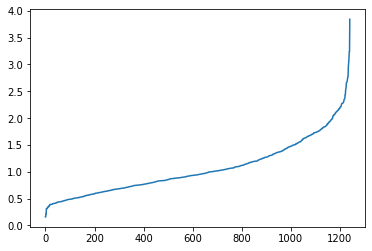

In [21]:
## On travail sur la DF_finale

from sklearn.neighbors import NearestNeighbors

##On cherche le epsilon optimal 
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(DF_finale_bis[list(DF_finale_bis.columns[5:])])
distances, indices = nbrs.kneighbors(DF_finale_bis[list(DF_finale_bis.columns[5:])])
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
print(distances[int(0.95*len(DF_finale_bis))])

In [22]:
# Fonction qui trace les courbes des véhicules présents dans chaque clusters et 
# donne en légende les couples correspondants

def cluster_dbscan_total(df,epsilon,nb_voisin):
    
    # ON supprime les Nan de la df
    df = df.dropna()
    
    # On normalise les indicateurs 
    df[list(df.columns[5:])] = StandardScaler().fit_transform(df[list(df.columns[5:])])
    
    labels = cluster (df[list(df.columns[5:])],epsilon,nb_voisin)
    df['clusters']=labels
    
    # ON met les labels dans la dataframe
    df = df.sort_values(by=['scene'])
    liste_scene = list(df['scene'].unique())
    
    # Liste des labels uniques et dans l'ordre
    labels_unique = sorted(list(set(labels)))
    
    nb_scene = len(df['scene'].unique())

    
    fig, axs = plt.subplots(len(labels_unique),nb_scene) # Ici on aura 10 scènes pour commencer 
    #fig.suptitle("Tracé des clusters obtenus avec l'algorithme DSCAN")
    plt.gcf().set_size_inches(20, 20)
    #plt.gcf().subplots_adjust(left = 0.3, bottom = 0.3,right = 0.7, top = 0.9, wspace = 0, hspace = 0.5)
    
    for s in labels_unique:
        
        # On s'occupe d'un cluster 
        df_new = df[df['clusters']==s]
        
        # On classe les lignes par scènes 
        df_new = df_new.sort_values(by=['scene'])
        # On cherche les scènes dans le cluster 
        scene_in_cluster = df_new['scene'].unique()
        
        for h in range(0,len(scene_in_cluster)) :
            # ON s'occupe d'une scene  
        
            # On récupère la place de cette scène dans l'ordre 
            num_scene = liste_scene.index(scene_in_cluster[h])
            
            df_bis = df_new[df_new['scene']==scene_in_cluster[h]]

        
            nb_ligne = len(df_bis)

            Texte_legend = 'Couple de trajectoires \n'

            for j in range(0,nb_ligne):
                current_ligne = df_bis.iloc[j]

                scene_name = current_ligne['scene']
                veh1 = current_ligne['Catégorie Véhicule 1'] # catégorie du véhicule 1 
                veh2 = current_ligne['Catégorie Véhicule 2']# ici on a le nom de la catégorie 
                num_veh2 = current_ligne['Numéro Véhicule 2']-1 # Numéro du véhicule 2 

                scene_token = nusc.field2token('scene','name',scene_name)[0]
                sample_token = nusc.field2token('sample','scene_token',scene_token)# Ensemble des token des échantillons de la scene 

                # Ensemble des sample_annotation de la scène :

                sample_annotation_token = []
                for k in sample_token : 
                    L = nusc.field2token('sample_annotation','sample_token',k)
                    sample_annotation_token = sample_annotation_token + L

                # On créé la liste des token des instances présents dans les sample_annotation
                L_instance_token = []
                for k in sample_annotation_token :
                    exemple = nusc.get('sample_annotation', k)
                    L_instance_token.append(exemple['instance_token'])
                # Puisque pour un même objet, on peut avoir plusieurs annotations, on supprime les doublons de L
                L_instance_token = list(set(L_instance_token))

                ## Véhicule 1 
                if veh1 == 'vehicle.ego':              
                    num_veh1_legend = ''
                    Liste_ego_poses = get_poses(scene_token) 
                    X1 =[]
                    Y1 =[]
                    Z1 =[]
                    T1 = [] # liste des timestamps
                    for k in range(0,len(Liste_ego_poses)):
                        X1.append(Liste_ego_poses[k]['translation'][0])
                        Y1.append(Liste_ego_poses[k]['translation'][1])
                        Z1.append(Liste_ego_poses[k]['translation'][2])
                        T1.append(Liste_ego_poses[k]['timestamp'])
                else :
                    num_veh1 = current_ligne['Numéro Véhicule 1']-1 #numéro du véhicule dans la liste de tous les véh de cette catégo
                    num_veh1_legend = str(num_veh1+1)

                    catego_name = veh1
                    catego_token = nusc.field2token('category','name',catego_name)
                    category = nusc.get('category',catego_token[0])

                    # Ensemble des instances appartenant à la fois à la scène et à la catégorie
                    L_instance_category = nusc.field2token('instance','category_token',catego_token[0]) # instance dans la catégorie
                    L_instance_category = [x for x in L_instance_category if x in L_instance_token]# et dans la scène 

                    L=[]
                    for k in L_instance_category : 
                        instance_category = nusc.get('instance',k)
                        nbr_annotations = instance_category['nbr_annotations']
                        if nbr_annotations == 1:
                            L.append([instance_category['first_annotation_token']])
                        else : 
                            H = []
                            first_token = instance_category['first_annotation_token']
                            last_token = instance_category['last_annotation_token']
                            current_token = first_token 

                            i = 0 
                            while i!= nbr_annotations :
                                current_ann = nusc.get('sample_annotation', current_token)
                                H.append(current_ann['token'])
                                current_token = current_ann['next'] #On passe au suivant
                                i+=1
                            L.append(H)
                    # Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
                    # les token des sample_annotation pour un élément de cette catégorie. 

                    # Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
                    # on va pouvoir récupérer leurs positions 

                    X = []
                    Y = []
                    Z = []
                    T_time = []
                    for k in L :
                        x = []
                        y = []
                        z = []
                        t = []
                        for i in k :
                            sample_annotation = nusc.get('sample_annotation',i)
                            x.append(sample_annotation['translation'][0])
                            y.append(sample_annotation['translation'][1])
                            z.append(sample_annotation['translation'][2])
                            t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
                        X.append(x)
                        Y.append(y)
                        Z.append(z)
                        T_time.append(t)

                    Immo, Mobile = immobile(X,Y)

                    # On conserve uniquement les objets mobiles 
                    X_mobile=[X[i] for i in Mobile]
                    Y_mobile=[Y[i] for i in Mobile]
                    Z_mobile=[Z[i] for i in Mobile]
                    T_mobile = [T_time[i] for i in Mobile]

                    X1 =X_mobile[num_veh1] 
                    Y1 =Y_mobile[num_veh1] 
                    Z1 =Z_mobile[num_veh1] 
                    T1 =T_mobile[num_veh1] 

                catego_name = veh2
                catego_token = nusc.field2token('category','name',catego_name)
                category = nusc.get('category',catego_token[0])

                # Ensemble des instances appartenant à la fois à la scène et à la catégorie
                L_instance_category = nusc.field2token('instance','category_token',catego_token[0]) # instance dans la catégorie
                L_instance_category = [x for x in L_instance_category if x in L_instance_token]# et dans la scène 

                L=[]
                for k in L_instance_category : 
                    instance_category = nusc.get('instance',k)
                    nbr_annotations = instance_category['nbr_annotations']
                    if nbr_annotations == 1:
                        L.append([instance_category['first_annotation_token']])
                    else : 
                        H = []
                        first_token = instance_category['first_annotation_token']
                        last_token = instance_category['last_annotation_token']
                        current_token = first_token 

                        i = 0 
                        while i!= nbr_annotations :
                            current_ann = nusc.get('sample_annotation', current_token)
                            H.append(current_ann['token'])
                            current_token = current_ann['next'] #On passe au suivant
                            i+=1
                        L.append(H)
                    # Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
                    # les token des sample_annotation pour un élément de cette catégorie. 

                    # Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
                    # on va pouvoir récupérer leurs positions 

                X = []
                Y = []
                Z = []
                T_time = []
                for k in L :
                    x = []
                    y = []
                    z = []
                    t = []
                    for i in k :
                        sample_annotation = nusc.get('sample_annotation',i)
                        x.append(sample_annotation['translation'][0])
                        y.append(sample_annotation['translation'][1])
                        z.append(sample_annotation['translation'][2])
                        t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
                    X.append(x)
                    Y.append(y)
                    Z.append(z)
                    T_time.append(t)

                Immo, Mobile = immobile(X,Y)

                # On conserve uniquement les objets mobiles 
                X_mobile=[X[i] for i in Mobile]
                Y_mobile=[Y[i] for i in Mobile]
                Z_mobile=[Z[i] for i in Mobile]
                T_mobile = [T_time[i] for i in Mobile]

                X2 =X_mobile[num_veh2] 
                Y2 =Y_mobile[num_veh2] 
                Z2 =Z_mobile[num_veh2] 
                T2 =T_mobile[num_veh2] 

                axs[s,num_scene].plot(X1,Y1)
                #axs[s,h].text(X1[0], Y1[0],veh1 + ' '+num_veh1_legend)#,fontsize=8)
                axs[s,num_scene].plot(X2,Y2)
                #axs[s,h].text(X2[0], Y2[0],veh2 + ' '+str(num_veh2+1))#,fontsize=8)
                #axs[s,h].legend(loc='best')
                #axs[s,num_scene].set_title('Cluster '+str(s)+' dans '+ scene_name)
                #axs[s,h].plot([],[],'w',label = veh1 + ' '+num_veh1_legend +'/'+veh2 + ' '+str(num_veh2+1))   

    plt.tight_layout()
    plt.show()

/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a co

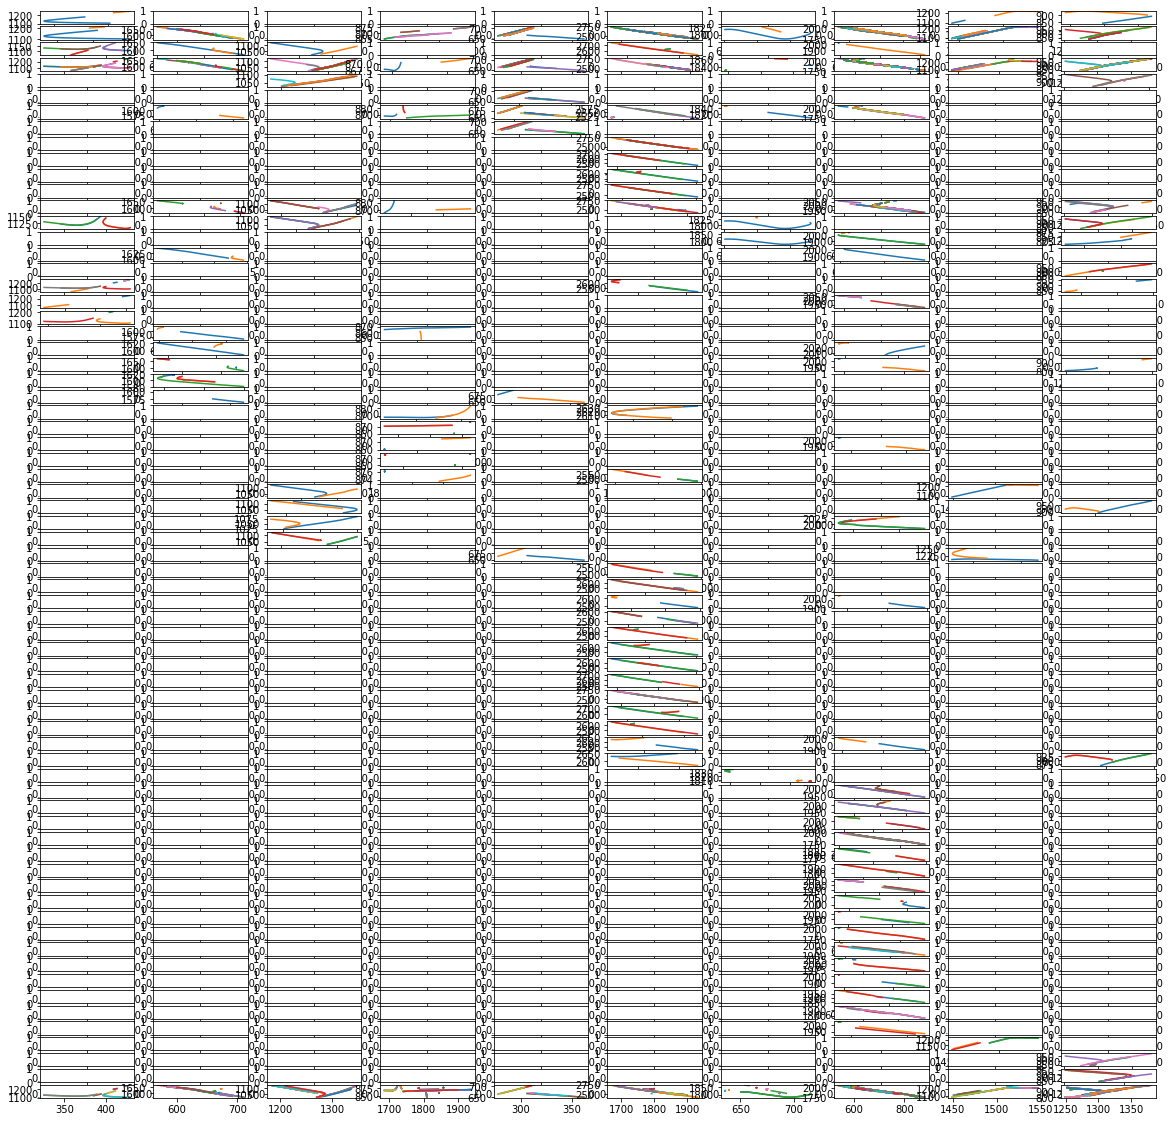

In [23]:
cluster_dbscan_total(DF_finale,1.5,2)

### Automatisation de la compréhension des clusters : approche manuelle 

In [24]:
#On trace le résultat du clustering par cluster 

def cluster_dbscan_total_cluster(df,epsilon,nb_voisin,num_cluster):
    
    # ON supprime les Nan de la df
    df = df.dropna()
    
    # On normalise les indicateurs 
    df[list(df.columns[5:])] = StandardScaler().fit_transform(df[list(df.columns[5:])])
    
    labels = cluster (df[list(df.columns[5:])],epsilon,nb_voisin)
    df['clusters']=labels
    
    # On garde uniquement la scène voulue 
    df = df[df['clusters']==num_cluster]
    liste_scene = list(df['scene'].unique())
    
    # Liste des labels uniques et dans l'ordre
    labels_unique = sorted(list(set(df['clusters'].values)))
    
    nb_scene = len(df['scene'].unique())

    
    fig, axs = plt.subplots(3) # Ici on aura 10 scènes pour commencer 
    #fig.suptitle("Tracé des clusters obtenus avec l'algorithme DSCAN")
    plt.gcf().set_size_inches(20, 20)
    #plt.gcf().subplots_adjust(left = 0.3, bottom = 0.3,right = 0.7, top = 0.9, wspace = 0, hspace = 0.5)
    
    counter = -1 
    for s in labels_unique:
        
        # On s'occupe d'un cluster 
        df_new = df[df['clusters']==s]
        
        # On classe les lignes par scènes 
        df_new = df_new.sort_values(by=['scene'])
        # On cherche les scènes dans le cluster 
        scene_in_cluster = df_new['scene'].unique()
        
        for h in range(0,len(scene_in_cluster[:3])) :
            # ON s'occupe d'une scene  
        
            # On récupère la place de cette scène dans l'ordre 
            num_scene = liste_scene.index(scene_in_cluster[h])
            
            df_bis = df_new[df_new['scene']==scene_in_cluster[h]]

        
            nb_ligne = len(df_bis)

            Texte_legend = 'Couple de trajectoires \n'

            for j in range(0,nb_ligne):
                current_ligne = df_bis.iloc[j]

                scene_name = current_ligne['scene']
                veh1 = current_ligne['Catégorie Véhicule 1'] # catégorie du véhicule 1 
                veh2 = current_ligne['Catégorie Véhicule 2']# ici on a le nom de la catégorie 
                num_veh2 = current_ligne['Numéro Véhicule 2']-1 # Numéro du véhicule 2 

                scene_token = nusc.field2token('scene','name',scene_name)[0]
                sample_token = nusc.field2token('sample','scene_token',scene_token)# Ensemble des token des échantillons de la scene 

                # Ensemble des sample_annotation de la scène :

                sample_annotation_token = []
                for k in sample_token : 
                    L = nusc.field2token('sample_annotation','sample_token',k)
                    sample_annotation_token = sample_annotation_token + L

                # On créé la liste des token des instances présents dans les sample_annotation
                L_instance_token = []
                for k in sample_annotation_token :
                    exemple = nusc.get('sample_annotation', k)
                    L_instance_token.append(exemple['instance_token'])
                # Puisque pour un même objet, on peut avoir plusieurs annotations, on supprime les doublons de L
                L_instance_token = list(set(L_instance_token))

                ## Véhicule 1 
                if veh1 == 'vehicle.ego':              
                    num_veh1_legend = ''
                    Liste_ego_poses = get_poses(scene_token) 
                    X1 =[]
                    Y1 =[]
                    Z1 =[]
                    T1 = [] # liste des timestamps
                    for k in range(0,len(Liste_ego_poses)):
                        X1.append(Liste_ego_poses[k]['translation'][0])
                        Y1.append(Liste_ego_poses[k]['translation'][1])
                        Z1.append(Liste_ego_poses[k]['translation'][2])
                        T1.append(Liste_ego_poses[k]['timestamp'])
                else :
                    num_veh1 = current_ligne['Numéro Véhicule 1']-1 #numéro du véhicule dans la liste de tous les véh de cette catégo
                    num_veh1_legend = str(num_veh1+1)

                    catego_name = veh1
                    catego_token = nusc.field2token('category','name',catego_name)
                    category = nusc.get('category',catego_token[0])

                    # Ensemble des instances appartenant à la fois à la scène et à la catégorie
                    L_instance_category = nusc.field2token('instance','category_token',catego_token[0]) # instance dans la catégorie
                    L_instance_category = [x for x in L_instance_category if x in L_instance_token]# et dans la scène 

                    L=[]
                    for k in L_instance_category : 
                        instance_category = nusc.get('instance',k)
                        nbr_annotations = instance_category['nbr_annotations']
                        if nbr_annotations == 1:
                            L.append([instance_category['first_annotation_token']])
                        else : 
                            H = []
                            first_token = instance_category['first_annotation_token']
                            last_token = instance_category['last_annotation_token']
                            current_token = first_token 

                            i = 0 
                            while i!= nbr_annotations :
                                current_ann = nusc.get('sample_annotation', current_token)
                                H.append(current_ann['token'])
                                current_token = current_ann['next'] #On passe au suivant
                                i+=1
                            L.append(H)
                    # Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
                    # les token des sample_annotation pour un élément de cette catégorie. 

                    # Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
                    # on va pouvoir récupérer leurs positions 

                    X = []
                    Y = []
                    Z = []
                    T_time = []
                    for k in L :
                        x = []
                        y = []
                        z = []
                        t = []
                        for i in k :
                            sample_annotation = nusc.get('sample_annotation',i)
                            x.append(sample_annotation['translation'][0])
                            y.append(sample_annotation['translation'][1])
                            z.append(sample_annotation['translation'][2])
                            t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
                        X.append(x)
                        Y.append(y)
                        Z.append(z)
                        T_time.append(t)

                    Immo, Mobile = immobile(X,Y)

                    # On conserve uniquement les objets mobiles 
                    X_mobile=[X[i] for i in Mobile]
                    Y_mobile=[Y[i] for i in Mobile]
                    Z_mobile=[Z[i] for i in Mobile]
                    T_mobile = [T_time[i] for i in Mobile]

                    X1 =X_mobile[num_veh1] 
                    Y1 =Y_mobile[num_veh1] 
                    Z1 =Z_mobile[num_veh1] 
                    T1 =T_mobile[num_veh1] 

                catego_name = veh2
                catego_token = nusc.field2token('category','name',catego_name)
                category = nusc.get('category',catego_token[0])

                # Ensemble des instances appartenant à la fois à la scène et à la catégorie
                L_instance_category = nusc.field2token('instance','category_token',catego_token[0]) # instance dans la catégorie
                L_instance_category = [x for x in L_instance_category if x in L_instance_token]# et dans la scène 

                L=[]
                for k in L_instance_category : 
                    instance_category = nusc.get('instance',k)
                    nbr_annotations = instance_category['nbr_annotations']
                    if nbr_annotations == 1:
                        L.append([instance_category['first_annotation_token']])
                    else : 
                        H = []
                        first_token = instance_category['first_annotation_token']
                        last_token = instance_category['last_annotation_token']
                        current_token = first_token 

                        i = 0 
                        while i!= nbr_annotations :
                            current_ann = nusc.get('sample_annotation', current_token)
                            H.append(current_ann['token'])
                            current_token = current_ann['next'] #On passe au suivant
                            i+=1
                        L.append(H)
                    # Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
                    # les token des sample_annotation pour un élément de cette catégorie. 

                    # Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
                    # on va pouvoir récupérer leurs positions 

                X = []
                Y = []
                Z = []
                T_time = []
                for k in L :
                    x = []
                    y = []
                    z = []
                    t = []
                    for i in k :
                        sample_annotation = nusc.get('sample_annotation',i)
                        x.append(sample_annotation['translation'][0])
                        y.append(sample_annotation['translation'][1])
                        z.append(sample_annotation['translation'][2])
                        t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
                    X.append(x)
                    Y.append(y)
                    Z.append(z)
                    T_time.append(t)

                Immo, Mobile = immobile(X,Y)

                # On conserve uniquement les objets mobiles 
                X_mobile=[X[i] for i in Mobile]
                Y_mobile=[Y[i] for i in Mobile]
                Z_mobile=[Z[i] for i in Mobile]
                T_mobile = [T_time[i] for i in Mobile]

                X2 =X_mobile[num_veh2] 
                Y2 =Y_mobile[num_veh2] 
                Z2 =Z_mobile[num_veh2] 
                T2 =T_mobile[num_veh2] 
                
               # print(counter)

                axs[h].plot(X1,Y1)
                axs[h].text(X1[0], Y1[0],veh1 + ' '+num_veh1_legend)#,fontsize=8)
                axs[h].plot(X2,Y2)
                axs[h].text(X2[0], Y2[0],veh2 + ' '+str(num_veh2+1))#,fontsize=8)
                axs[h].set_title('Cluster '+str(s)+' dans '+ scene_name)
                axs[h].plot([],[],'w',label = veh1 + ' '+num_veh1_legend +'/'+veh2 + ' '+str(num_veh2+1)) 
                axs[h].legend(loc='best')

    plt.tight_layout()
    plt.show()

/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

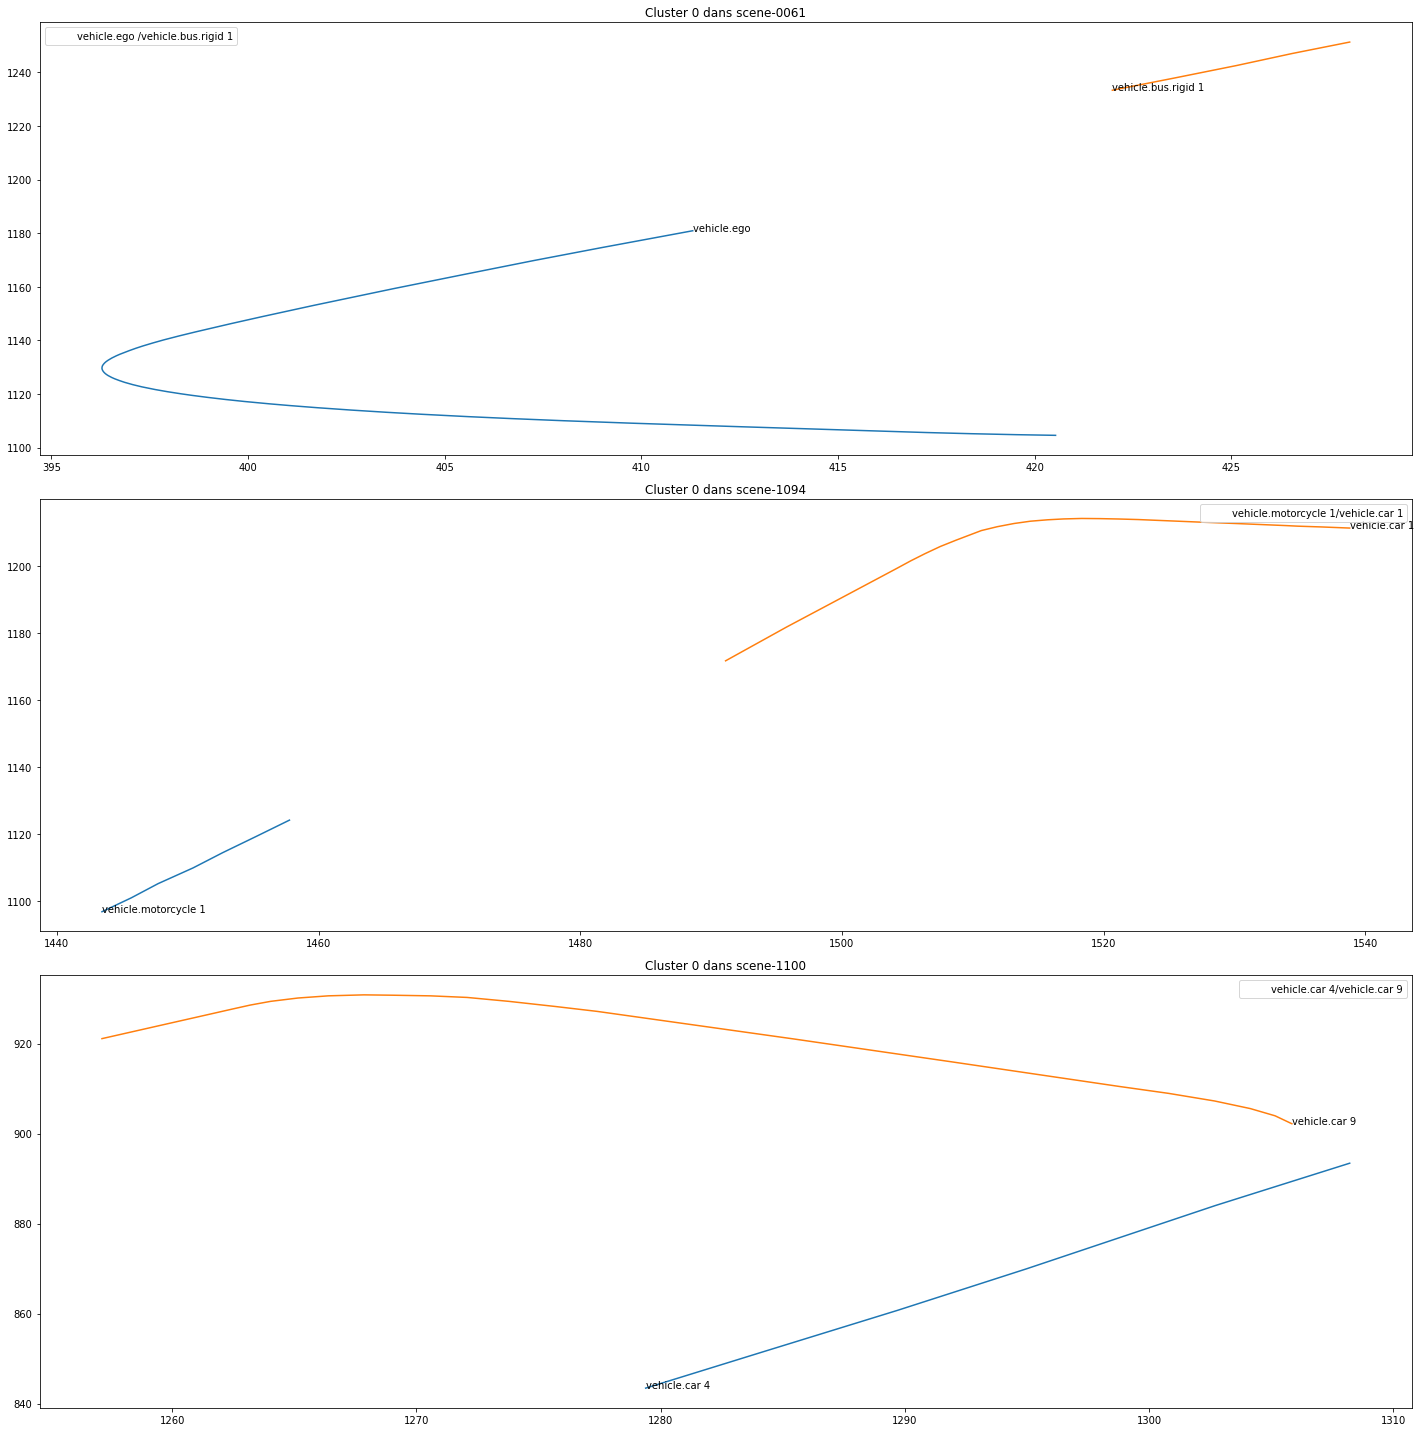

In [25]:
cluster_dbscan_total_cluster(DF_finale,1.5,2,0)

In [26]:
def description_cluster_dbscan(df,epsilon,nb_voisin):
    
    df_cluster = pd.DataFrame()
    
    # ON supprime les Nan de la df
    df = df.dropna()
    
    # On normalise les indicateurs 
    df[list(df.columns[5:])] = StandardScaler().fit_transform(df[list(df.columns[5:])])
    
    labels = cluster (df[list(df.columns[5:])],epsilon,nb_voisin)
    df['clusters']=labels
    
    # ON met les labels dans la dataframe
    df = df.sort_values(by=['scene'])
    liste_scene = list(df['scene'].unique())
    
    # Liste des labels uniques et dans l'ordre
    labels_unique = sorted(list(set(labels)))
    
    nb_scene = len(df['scene'].unique())

    Colonne = []
    for k in liste_scene :
        Colonne.append('Nbre élément '+k)
        Colonne.append('Éléments '+k)
        
    df_cluster['Colonne']=Colonne
    df_cluster =df_cluster.set_index('Colonne')

    for s in labels_unique:
        
        L = [] # liste qu'on va mettre dans la df 
        
        # On s'occupe d'un cluster 
        df_new = df[df['clusters']==s]
        
        # On classe les lignes par scènes 
        df_new = df_new.sort_values(by=['scene'])
        # On cherche les scènes dans le cluster 
        scene_in_cluster = df_new['scene'].unique()
        
        for h in range(0,nb_scene) :
            
            # ON s'occupe d'une scene  
            df_bis = df_new[df_new['scene']==liste_scene[h]]
            
            # On regarde combien d'éléments sont dans le cluster s et dans la scène 
            nb_ligne = len(df_bis)
            L.append(len(df_bis))
            
            if nb_ligne ==0:
                L.append(np.nan) # Il n'y a pas d'élément de cette scène dans le cluster 
            else : 
                L_element = []
                for j in range(0,nb_ligne):
                    L_element.append(df_bis.iloc[j].name)
                L.append(L_element)
                    
        df_cluster['Cluster ' +str(s)]=L
    return df_cluster.transpose()

In [27]:
description_cluster_dbscan(DF_finale,1.5,2)

/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

Colonne,Nbre élément scene-0061,Éléments scene-0061,Nbre élément scene-0103,Éléments scene-0103,Nbre élément scene-0553,Éléments scene-0553,Nbre élément scene-0655,Éléments scene-0655,Nbre élément scene-0757,Éléments scene-0757,Nbre élément scene-0796,Éléments scene-0796,Nbre élément scene-0916,Éléments scene-0916,Nbre élément scene-1077,Éléments scene-1077,Nbre élément scene-1094,Éléments scene-1094,Nbre élément scene-1100,Éléments scene-1100
Cluster -1,5,"[vehicle.car 1 /vehicle.car 3 scene-0061, vehi...",18,"[vehicle.car 11/ego dans scene-0103, vehicle.c...",12,"[vehicle.car 7/ego dans scene-0553, vehicle.tr...",31,"[vehicle.car 4 /vehicle.car 8 scene-0655, vehi...",5,"[vehicle.car 6/ego dans scene-0757, vehicle.tr...",25,"[vehicle.car 3 /vehicle.car 11 scene-0796, veh...",8,"[vehicle.car 1 /vehicle.car 3 scene-0916, vehi...",82,"[vehicle.car 8/ego dans scene-1077, vehicle.ca...",10,"[vehicle.car 4/ego dans scene-1094, vehicle.bu...",31,[vehicle.bus.rigid 1 /vehicle.car 9 scene-1100...
Cluster 0,1,[vehicle.bus.rigid 1/ego dans scene-0061],0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,1,[vehicle.motorcycle 1 /vehicle.car 1 scene-1094],1,[vehicle.car 4 /vehicle.car 9 scene-1100]
Cluster 1,1,[vehicle.car 1/ego dans scene-0061],12,"[vehicle.car 5/ego dans scene-0103, vehicle.ca...",0,NaN,4,"[vehicle.car 1 /vehicle.car 6 scene-0655, vehi...",16,"[vehicle.car 1 /vehicle.car 2 scene-0757, vehi...",51,"[vehicle.car 4 /vehicle.car 12 scene-0796, veh...",1,[vehicle.truck 1/ego dans scene-0916],96,"[vehicle.car 11/ego dans scene-1077, vehicle.c...",11,"[vehicle.bus.rigid 1/ego dans scene-1094, vehi...",7,"[vehicle.car 2 /vehicle.car 5 scene-1100, vehi..."
Cluster 2,3,"[vehicle.car 4 /vehicle.car 5 scene-0061, vehi...",1,[vehicle.car 2/ego dans scene-0103],1,[vehicle.bus.rigid 1 /vehicle.car 5 scene-0553],0,NaN,0,NaN,2,"[vehicle.car 3 /vehicle.car 9 scene-0796, vehi...",0,NaN,1,[vehicle.car 21 /vehicle.car 35 scene-1077],0,NaN,0,NaN
Cluster 3,9,"[vehicle.car 3 /vehicle.car 5 scene-0061, vehi...",7,"[vehicle.car 1/ego dans scene-0103, vehicle.bi...",17,"[vehicle.car 6 /vehicle.car 10 scene-0553, veh...",1,[vehicle.truck 1 /vehicle.car 6 scene-0655],13,"[vehicle.car 4/ego dans scene-0757, vehicle.ca...",29,"[vehicle.car 2 /vehicle.car 16 scene-0796, veh...",2,"[vehicle.car 1 /vehicle.car 6 scene-0916, vehi...",420,"[vehicle.car 4 /vehicle.car 42 scene-1077, veh...",14,"[vehicle.car 3/ego dans scene-1094, vehicle.ca...",25,"[vehicle.car 8 /vehicle.car 11 scene-1100, veh..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cluster 63,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,4,"[vehicle.car 32 /vehicle.car 48 scene-1077, ve...",0,NaN,0,NaN
Cluster 64,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,2,"[vehicle.car 33 /vehicle.car 40 scene-1077, ve...",0,NaN,0,NaN
Cluster 65,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,2,"[vehicle.car 1 /vehicle.car 6 scene-1094, vehi...",0,NaN
Cluster 66,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0,NaN,4,"[vehicle.car 5 /vehicle.car 12 scene-1100, veh..."


### Automatisation de la compréhension des clusters : approche automatique 

In [28]:
# Fonction qui renvoie une df avec pour chaque cluster les valeurs moyennes de chaque indicateur normalisé -> Les centroides

def centroide_dbscan(df,epsilon,nb_voisin):
    
    df_cluster = pd.DataFrame()
    
    df = df.dropna()
    
    # On normalise les indicateurs 
    df[list(df.columns[5:])] = StandardScaler().fit_transform(df[list(df.columns[5:])])
    
    labels = cluster (df[list(df.columns[5:])],epsilon,nb_voisin)
    df['clusters']=labels
    
    # ON met les labels dans la dataframe
    df = df.sort_values(by=['clusters'])
    
    # Liste des labels uniques et dans l'ordre
    labels_unique = sorted(list(set(labels)))
    
    Colonne_index = ['Cluster '+str(labels_unique[k]) for k in range(0,len(labels_unique))]
    df_cluster['Cluster']=Colonne_index
    df_cluster = df_cluster.set_index('Cluster') # On met la liste des noms des clusters en index
    
    # ON prépare les listes qui seront dans la df_cluster
    L_liste_traj = []
    L_nbr_element = [] 
    L_vit_veh1 = []
    L_vit_veh2 = []
    L_duree = []
    L_DTW_moy = []
    L_dist_moy = []
    L_DTW_min = []
    L_DTW_max =[]
    L_TL_horizon =[]
    L_TL_vertical = []
    L_indic_ortho_moy = []
    L_indic_ortho_min = []
    L_indic_ortho_max = []
    L_indic_coli_moy = []
    L_indic_coli_min = []
    L_indic_coli_max = []
    L_sens = []
    L_dist_mat_min = []
    L_dist_mat_max = []
    L_dist_mat_moy = []
    
    for s in labels_unique:
        
        # On s'occupe d'un cluster 
        df_bis = df[df['clusters']==s]
        nb_ligne = len(df_bis)
        
        L_cluster_s =[]
        
        for j in range(0,nb_ligne):
            current_ligne = df_bis.iloc[j]
            L_cluster_s.append(current_ligne.name) # Nom du couple de traj 
        
        L_liste_traj.append(L_cluster_s)
        L_nbr_element.append(len(L_cluster_s))
        
        L_vit_veh1.append(np.mean(df_bis['Vitesse moyenne veh 1']))
        L_vit_veh2.append(np.mean(df_bis['Vitesse moyenne veh 2']))
        L_duree.append(np.mean(df_bis["Durée d'interaction"]))
        L_DTW_moy.append(np.mean(df_bis['DTW normalisée']))
        L_dist_moy.append(np.mean(df_bis['Distance instantannée moyenne']))
        L_DTW_min.append(np.mean(df_bis["Distance instantannée minimale"]))
        L_DTW_max.append(np.mean(df_bis['Distance instantannée maximale']))
        L_TL_horizon.append(np.mean(df_bis['TimeLag moyen horizontal']))
        L_TL_vertical.append(np.mean(df_bis['TimeLag moyen vertical']))
        L_indic_ortho_moy.append(np.mean(df_bis["Indicateur d'orthogonalité moyen"]))
        L_indic_ortho_min.append(np.mean(df_bis["Indicateur d'orthogonalité min"]))
        L_indic_ortho_max.append(np.mean(df_bis["Indicateur d'orthogonalité max"]))
  
        L_indic_coli_moy.append(np.mean(df_bis['Indicateur de colinéarité moyen']))
        L_indic_coli_min.append(np.mean(df_bis['Indicateur de colinéarité min']))
        L_indic_coli_max.append(np.mean(df_bis['Indicateur de colinéarité max']))
        
        L_sens.append(np.mean(df_bis['Sens']))
        
        L_dist_mat_min.append(np.mean(df_bis['Distance minimale dans matrice distance']))
        L_dist_mat_max.append(np.mean(df_bis['Distance maximale dans matrice distance']))
        L_dist_mat_moy.append(np.mean(df_bis['Distance moyenne dans matrice distance']))
            
    df_cluster['Liste des trajectoires appartenant au cluster'] = L_liste_traj
    df_cluster['Nbre élement dans cluster']=L_nbr_element
    df_cluster['Vitesse veh 1 moyenne'] = L_vit_veh1
    df_cluster['Vitesse veh 2 moyenne'] = L_vit_veh2
    df_cluster['Durée interaction moyenne'] =  L_duree
    df_cluster['DTW moyen'] = L_DTW_moy
    df_cluster['Distance instantannée moyenne moyenne'] = L_dist_moy
    df_cluster['Distance instantannée minimale moyenne'] = L_DTW_min
    df_cluster['Distance instantannée maximale moyenne'] = L_DTW_max
    df_cluster['TimeLag horizontal moyen'] =  L_TL_horizon
    df_cluster['TimeLag vertical moyen'] =  L_TL_vertical
    df_cluster["Indicateur d'orthogonalité moyen" ] = L_indic_ortho_moy
    df_cluster["Indicateur d'orthogonalité minimal moyen" ] = L_indic_ortho_min
    df_cluster["Indicateur d'orthogonalité maximal moyen" ] = L_indic_ortho_max
    df_cluster["Indicateur de colinéarité moyen" ] = L_indic_coli_moy
    df_cluster["Indicateur de colinéarité minimal moyen" ] = L_indic_coli_min
    df_cluster["Indicateur de colinéarité maximal moyen" ] = L_indic_coli_max
    df_cluster['Sens'] = L_sens
    df_cluster["Distance minimale moyenne" ] = L_dist_mat_min
    df_cluster["Distance maximale moyenne" ] = L_dist_mat_max
    df_cluster["Distance moyenne moyenne" ] = L_dist_mat_moy
    
    return df_cluster

In [29]:
centroide_dbscan(DF_finale,1.5,2)

/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a co

,Liste des trajectoires appartenant au cluster,Nbre élement dans cluster,Vitesse veh 1 moyenne,Vitesse veh 2 moyenne,Durée interaction moyenne,DTW moyen,Distance instantannée moyenne moyenne,Distance instantannée minimale moyenne,Distance instantannée maximale moyenne,TimeLag horizontal moyen,...,Indicateur d'orthogonalité moyen,Indicateur d'orthogonalité minimal moyen,Indicateur d'orthogonalité maximal moyen,Indicateur de colinéarité moyen,Indicateur de colinéarité minimal moyen,Indicateur de colinéarité maximal moyen,Sens,Distance minimale moyenne,Distance maximale moyenne,Distance moyenne moyenne
Cluster,,,,,,,,,,,,,,,,,,,,,
Cluster -1,[vehicle.motorcycle 1 /vehicle.motorcycle 2 sc...,227,-0.625431,-0.592191,0.271025,0.152380,0.158009,0.057283,0.262472,0.584113,...,0.719958,0.416499,0.881463,-0.372084,-0.578166,-0.173113,-0.391526,0.113762,0.035149,0.107758
Cluster 0,"[vehicle.car 4 /vehicle.car 9 scene-1100, vehi...",3,0.059310,-0.777114,-1.093423,0.445539,0.335136,0.258621,0.341920,0.224825,...,-0.629305,-0.430660,-0.752044,-1.476359,-1.302666,-1.596635,-1.349242,0.403551,-0.188800,0.217690
Cluster 1,"[vehicle.car 11 /vehicle.car 35 scene-1077, ve...",199,0.545852,0.492201,-0.415591,-0.343388,-0.382348,-0.747979,0.153486,-0.472122,...,-0.670440,-0.536687,-0.651785,-1.476996,-1.305933,-1.581231,-1.349242,-0.607410,-0.242353,-0.621151
Cluster 2,"[vehicle.car 4 /vehicle.car 5 scene-0061, vehi...",8,-1.091204,-0.173093,0.085846,-0.514651,-0.477016,-0.547848,-0.230034,1.684441,...,0.694185,-0.332326,1.543972,0.575704,0.012777,0.771027,0.741157,-0.541869,-0.207321,-0.464623
Cluster 3,"[vehicle.car 19 /vehicle.car 46 scene-1077, ve...",537,0.259901,0.194421,0.100662,0.004159,0.026276,0.215211,-0.224210,-0.074227,...,-0.572340,-0.434706,-0.622902,0.869037,0.932412,0.772556,0.741157,0.115538,0.019906,0.115584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cluster 63,"[vehicle.car 32 /vehicle.car 48 scene-1077, ve...",4,1.938398,0.639986,-0.894926,1.713630,1.283300,0.373051,1.972206,-0.594048,...,-0.598331,-0.426972,-0.667050,-1.476981,-1.304438,-1.594079,-1.349242,0.717933,1.550959,1.437600
Cluster 64,"[vehicle.car 33 /vehicle.car 40 scene-1077, ve...",2,-1.979818,-0.021835,1.297611,0.439020,0.483678,0.025232,0.582078,-0.594048,...,0.661233,0.933585,0.355158,-1.333833,-1.181001,-1.445043,-1.349242,0.254709,0.276821,0.432034
Cluster 65,"[vehicle.car 1 /vehicle.car 6 scene-1094, vehi...",2,-0.953778,-0.664835,0.269170,0.092915,-0.166217,-0.896451,0.644405,-0.594048,...,0.449422,-0.581901,1.104993,-1.273231,-1.306559,-1.161496,-1.349242,-0.608878,0.173489,-0.166003


In [30]:
# Fonction qui renvoie une df avec pour chaque cluster les valeurs moyennes de chaque indicateur

def centroide_dbscan_realval(df,epsilon,nb_voisin):
    
    df_cluster = pd.DataFrame()
    
    df = df.dropna()
    
    # On normalise les indicateurs 
    df_bis = df.copy()
    df_bis[list(df_bis.columns[5:])] = StandardScaler().fit_transform(df_bis[list(df_bis.columns[5:])])
    
    labels = cluster (df_bis[list(df_bis.columns[5:])],epsilon,nb_voisin)
    df['clusters']=labels
    
    # ON met les labels dans la dataframe
    df = df.sort_values(by=['clusters'])
    
    # Liste des labels uniques et dans l'ordre
    labels_unique = sorted(list(set(labels)))
    
    Colonne_index = ['Cluster '+str(labels_unique[k]) for k in range(0,len(labels_unique))]
    df_cluster['Cluster']=Colonne_index
    df_cluster = df_cluster.set_index('Cluster') # On met la liste des noms des clusters en index
    
    # ON prépare les listes qui seront dans la df_cluster
    L_liste_traj = []
    L_nbr_element = [] 
    L_vit_veh1 = []
    L_vit_veh2 = []
    L_duree = []
    L_DTW_moy = []
    L_dist_moy = []
    L_DTW_min = []
    L_DTW_max =[]
    L_TL_horizon =[]
    L_TL_vertical = []
    L_indic_ortho_moy = []
    L_indic_ortho_min = []
    L_indic_ortho_max = []
    L_indic_coli_moy = []
    L_indic_coli_min = []
    L_indic_coli_max = []
    L_sens = []
    L_dist_mat_min = []
    L_dist_mat_max = []
    L_dist_mat_moy = []
    
    for s in labels_unique:
        
        # On s'occupe d'un cluster 
        df_bis = df[df['clusters']==s]
        nb_ligne = len(df_bis)
        
        L_cluster_s =[]
        
        for j in range(0,nb_ligne):
            current_ligne = df_bis.iloc[j]
            L_cluster_s.append(current_ligne.name) # Nom du couple de traj 
        
        L_liste_traj.append(L_cluster_s)
        L_nbr_element.append(len(L_cluster_s))
        
        L_vit_veh1.append(np.mean(df_bis['Vitesse moyenne veh 1']))
        L_vit_veh2.append(np.mean(df_bis['Vitesse moyenne veh 2']))
        L_duree.append(np.mean(df_bis["Durée d'interaction"]))
        L_DTW_moy.append(np.mean(df_bis['DTW normalisée']))
        L_dist_moy.append(np.mean(df_bis['Distance instantannée moyenne']))
        L_DTW_min.append(np.mean(df_bis["Distance instantannée minimale"]))
        L_DTW_max.append(np.mean(df_bis['Distance instantannée maximale']))
        L_TL_horizon.append(np.mean(df_bis['TimeLag moyen horizontal']))
        L_TL_vertical.append(np.mean(df_bis['TimeLag moyen vertical']))
        L_indic_ortho_moy.append(np.mean(df_bis["Indicateur d'orthogonalité moyen"]))
        L_indic_ortho_min.append(np.mean(df_bis["Indicateur d'orthogonalité min"]))
        L_indic_ortho_max.append(np.mean(df_bis["Indicateur d'orthogonalité max"]))
  
        L_indic_coli_moy.append(np.mean(df_bis['Indicateur de colinéarité moyen']))
        L_indic_coli_min.append(np.mean(df_bis['Indicateur de colinéarité min']))
        L_indic_coli_max.append(np.mean(df_bis['Indicateur de colinéarité max']))
        
        L_sens.append(np.mean(df_bis['Sens']))
        
        L_dist_mat_min.append(np.mean(df_bis['Distance minimale dans matrice distance']))
        L_dist_mat_max.append(np.mean(df_bis['Distance maximale dans matrice distance']))
        L_dist_mat_moy.append(np.mean(df_bis['Distance moyenne dans matrice distance']))
            
    df_cluster['Liste des trajectoires appartenant au cluster'] = L_liste_traj
    df_cluster['Nbre élement dans cluster']=L_nbr_element
    df_cluster['Vitesse veh 1 moyenne'] = L_vit_veh1
    df_cluster['Vitesse veh 2 moyenne'] = L_vit_veh2
    df_cluster['Durée interaction moyenne'] =  L_duree
    df_cluster['DTW moyen'] = L_DTW_moy
    df_cluster['Distance instantannée moyenne moyenne'] = L_dist_moy
    df_cluster['Distance instantannée minimale moyenne'] = L_DTW_min
    df_cluster['Distance instantannée maximale moyenne'] = L_DTW_max
    df_cluster['TimeLag horizontal moyen'] =  L_TL_horizon
    df_cluster['TimeLag vertical moyen'] =  L_TL_vertical
    df_cluster["Indicateur d'orthogonalité moyen" ] = L_indic_ortho_moy
    df_cluster["Indicateur d'orthogonalité minimal moyen" ] = L_indic_ortho_min
    df_cluster["Indicateur d'orthogonalité maximal moyen" ] = L_indic_ortho_max
    df_cluster["Indicateur de colinéarité moyen" ] = L_indic_coli_moy
    df_cluster["Indicateur de colinéarité minimal moyen" ] = L_indic_coli_min
    df_cluster["Indicateur de colinéarité maximal moyen" ] = L_indic_coli_max
    df_cluster['Sens'] = L_sens
    df_cluster["Distance minimale moyenne" ] = L_dist_mat_min
    df_cluster["Distance maximale moyenne" ] = L_dist_mat_max
    df_cluster["Distance moyenne moyenne" ] = L_dist_mat_moy
    
    return df_cluster

In [31]:
centroide_dbscan_realval(DF_finale,1.5,2)

/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Liste des trajectoires appartenant au cluster,Nbre élement dans cluster,Vitesse veh 1 moyenne,Vitesse veh 2 moyenne,Durée interaction moyenne,DTW moyen,Distance instantannée moyenne moyenne,Distance instantannée minimale moyenne,Distance instantannée maximale moyenne,TimeLag horizontal moyen,...,Indicateur d'orthogonalité moyen,Indicateur d'orthogonalité minimal moyen,Indicateur d'orthogonalité maximal moyen,Indicateur de colinéarité moyen,Indicateur de colinéarité minimal moyen,Indicateur de colinéarité maximal moyen,Sens,Distance minimale moyenne,Distance maximale moyenne,Distance moyenne moyenne
Cluster,,,,,,,,,,,,,,,,,,,,,
Cluster -1,[vehicle.motorcycle 1 /vehicle.motorcycle 2 sc...,227,6.528279,6.977740,0.476016,56.833983,54.231454,38.276648,73.389252,2.901745,...,0.502270,0.303104,0.692577,-0.059810,-0.354394,0.201656,0.45815,45.990860,106.271061,72.222041
Cluster 0,"[vehicle.car 4 /vehicle.car 9 scene-1100, vehi...",3,9.676933,6.204744,0.137455,68.071560,59.754614,44.682345,76.281542,2.016838,...,0.064280,0.048690,0.087379,-0.996022,-0.996544,-0.994631,0.00000,59.150187,94.521135,76.970093
Cluster 1,"[vehicle.car 11 /vehicle.car 35 scene-1077, ve...",199,11.914208,11.510590,0.305646,37.829849,37.382106,12.656783,69.421622,0.300297,...,0.050927,0.016848,0.124524,-0.996562,-0.999440,-0.981686,0.00000,13.242389,91.711329,40.739832
Cluster 2,"[vehicle.car 4 /vehicle.car 5 scene-0061, vehi...",8,4.386509,8.729603,0.430068,31.264845,34.430203,19.024062,55.459586,5.611790,...,0.493903,0.078221,0.938031,0.743731,0.169379,0.995085,1.00000,16.218633,93.549382,47.500433
Cluster 3,"[vehicle.car 19 /vehicle.car 46 scene-1077, ve...",537,10.599314,10.265842,0.433744,51.152267,50.123771,43.301224,55.671591,1.280290,...,0.082772,0.047475,0.135225,0.992421,0.984484,0.996370,1.00000,46.071487,105.471321,72.560070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cluster 63,"[vehicle.car 32 /vehicle.car 48 scene-1077, ve...",4,18.317571,12.128343,0.186708,116.680987,89.320121,48.323026,135.632114,0.000000,...,0.074335,0.049797,0.118868,-0.996549,-0.998114,-0.992484,0.00000,73.426285,185.801295,129.659047
Cluster 64,"[vehicle.car 33 /vehicle.car 40 scene-1077, ve...",2,0.300381,9.361875,0.730743,67.821670,64.386424,37.256933,85.024492,0.000000,...,0.483207,0.458392,0.497586,-0.875188,-0.888708,-0.867238,0.00000,52.391236,118.950904,86.227786
Cluster 65,"[vehicle.car 1 /vehicle.car 6 scene-1094, vehi...",2,5.018437,6.674082,0.475556,54.554516,44.121493,7.933055,87.293535,0.000000,...,0.414450,0.003270,0.775393,-0.823808,-0.999995,-0.628953,0.00000,13.175730,113.529387,60.398092


### Distance inter-cluster 

In [32]:
def dist_inter_cluster_dbscan(df,eps,nb_voisin):
    # Liste des centroïdes des clusters et de leurs caractéristiques 
    liste_cluster = centroide_dbscan(df,eps,nb_voisin)
    nb_cluster = len(liste_cluster)
    
    #df en forme de matrice des distances 
    df = pd.DataFrame()
    df['Distance']=list(liste_cluster.index)
    
    for k in range(len(list(liste_cluster.index))):
        L = []
        for j in range(len(list(liste_cluster.index))):
            dist = [(liste_cluster[column].iloc[k]-liste_cluster[column].iloc[j])**2 for column in liste_cluster.columns[2:]]
            L.append(sqrt(sum(dist)))
        df[list(liste_cluster.index)[k]]=L
    df = df.set_index('Distance')
    return df

In [33]:
dist_inter_cluster_dbscan(DF_finale,1.5,2)

/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a co

,Cluster -1,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,...,Cluster 58,Cluster 59,Cluster 60,Cluster 61,Cluster 62,Cluster 63,Cluster 64,Cluster 65,Cluster 66,Cluster 67
Distance,,,,,,,,,,,,,,,,,,,,,
Cluster -1,0.000000,3.582290,4.070037,3.042563,3.640498,3.771509,3.964953,3.676535,4.173652,6.497955,...,3.151982,3.988424,4.238062,9.687155,5.225574,5.731574,3.281751,2.821283,3.510183,3.721307
Cluster 0,3.582290,0.000000,2.598400,5.817268,4.881787,6.364864,4.722242,5.300309,6.253985,7.761242,...,4.853444,4.713922,6.960592,9.751287,6.208487,4.082076,4.118269,3.402509,4.084343,6.324179
Cluster 1,4.070037,2.598400,0.000000,5.746964,4.853207,5.966495,4.264519,5.224108,5.867249,6.819904,...,4.838542,5.752650,6.650691,11.662245,7.424485,4.838709,4.389898,3.084617,3.928688,6.705222
Cluster 2,3.042563,5.817268,5.746964,0.000000,4.103001,3.066964,4.691057,5.182977,3.275864,6.635392,...,4.566122,6.528863,4.971982,11.889770,6.079321,8.061607,5.813093,4.794828,5.292082,4.050624
Cluster 3,3.640498,4.881787,4.853207,4.103001,0.000000,5.328339,5.923400,5.905363,4.532998,4.907470,...,5.713308,6.199805,5.973657,11.081279,4.698268,6.229667,5.589069,5.190816,5.480082,5.784254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cluster 63,5.731574,4.082076,4.838709,8.061607,6.229667,8.761867,7.888771,7.406289,8.900321,7.923522,...,6.536941,5.503666,8.896877,8.179988,5.875747,0.000000,5.683726,5.530346,6.230325,7.874160
Cluster 64,3.281751,4.118269,4.389898,5.813093,5.589069,5.439203,4.573774,4.645893,5.970394,7.324638,...,4.236430,2.789802,4.644575,9.569821,6.905327,5.683726,0.000000,2.894320,4.086758,5.985487
Cluster 65,2.821283,3.402509,3.084617,4.794828,5.190816,4.506604,3.160945,4.369338,4.911354,7.070182,...,4.079139,4.515385,5.178259,10.637413,7.088114,5.530346,2.894320,0.000000,2.294768,5.895440


### Variance intra-cluster 

In [34]:
def variance_intra_cluster_dbscan(df,epsilon,nb_voisin):
    
    df_sortante = pd.DataFrame()
    
    # ON supprime les Nan de la df
    df = df.dropna()
    
    # On normalise les indicateurs 
    df[list(df.columns[5:])] = StandardScaler().fit_transform(df[list(df.columns[5:])])
    
    labels = cluster (df[list(df.columns[5:])],epsilon,nb_voisin)
    df['clusters']=labels
    
    df_centroide = centroide_dbscan(df,epsilon,nb_voisin)
    df_centroide = df_centroide[list(df_centroide.columns[2:])]
    
    labels_unique = list(set(labels)) # Liste des labels dans l'ordre
    
    ## On prépare la df 
    df_sortante['Cluster'] = labels_unique
    df_sortante = df_sortante.set_index('Cluster')
    
    Moyenne = []
    Variance = []
    
    for k in range(0,len(labels_unique)):
        
        num_cluster = labels_unique[k]
        df_bis = df[df['clusters']==num_cluster]
        df_bis = df_bis[list(df_bis.columns[5:len(df_bis.columns)-1])]
        
        centroide_cluster = df_centroide[df_centroide.index=='Cluster '+str(num_cluster)].iloc[0]
        
        L = [] # liste qui contiendra les distances de chaque point/ au centroide

        for j in range(0,len(df_bis)):
            
            l = [(df_bis.iloc[j][df_bis.columns[i]]-centroide_cluster[df_centroide.columns[i]])**2 for i in range(0,len(df_bis.columns))]
            L.append(sqrt(sum(l)))
        
        Moyenne.append(mean(L))
        L_variance = [(L[i]-mean(L))**2 for i in range(0,len(L))]
        Variance.append(sum(L_variance)/(len(L)-1))
    
    df_sortante['Distance inter-cluster moyenne']=Moyenne
    df_sortante['Variance']=Variance 
    
    return df_sortante
    

In [35]:
variance_intra_cluster_dbscan(DF_finale,1.5,2)

/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

,Distance inter-cluster moyenne,Variance
Cluster,,
0,0.923118,9.845080e-02
1,2.036252,5.703399e-01
2,1.394454,1.435249e-01
3,3.085810,1.671660e+00
4,1.287229,9.522161e-02
...,...,...
64,0.546559,1.232595e-32
65,0.367146,1.540744e-32
66,0.824449,8.292553e-02


### Indicateur de trafic 

#### Distance parcourue par les véhicules

In [36]:
# Fonction qui renvoie la distance parcourue de deux véhicules pendant le temps où ils interagissent 

def distance_parcourue(X_coord,Y_coord,T_timestamp,X_veh,Y_veh,T_veh):
    
    debut = max(T_timestamp[0],T_veh[0]) # Temps début detection vehicule 1 
    fin = min(T_timestamp[len(T_timestamp)-1],T_veh[len(T_veh)-1]) # Temps fin detection vehicule 1 

    # On va créer la liste des indices des élements du veh 1 qui sont en même temps que le veh 2
    L_indice_ego = []
    for k in range(0,len(T_timestamp)):
        if debut<=T_timestamp[k]<=fin:
            L_indice_ego.append(k)
            
    # Pareil pour le veh 
    L_indice_veh = []
    for k in range(0,len(T_veh)):
        if debut<=T_veh[k]<=fin:
            L_indice_veh.append(k)
    
    # On crée la liste des vecteurs pour le véhicule ego avec les points qu'on peut garder
    D_ego = [0]
    for k in range(0,len(L_indice_ego)-1):
        d = D_ego[k] + sqrt((X_coord[L_indice_ego[k+1]]-X_coord[L_indice_ego[k]])**2+(Y_coord[L_indice_ego[k+1]]-Y_coord[L_indice_ego[k]])**2)
        D_ego.append(d)
   
    # On crée la liste des vecteurs pour le veh avec les points qu'on peut garder
    D_veh = [0]
    for k in range(0,len(L_indice_veh)-1):
        d = D_veh[k] + sqrt((X_veh[L_indice_veh[k+1]]-X_veh[L_indice_veh[k]])**2+(Y_veh[L_indice_veh[k+1]]-Y_veh[L_indice_veh[k]])**2)
        D_veh.append(d)
     
    return D_ego[len(D_ego)-1], D_veh[len(D_veh)-1]

In [37]:
#imports nécessaires
import matplotlib.pyplot as plt
from math import sqrt
import datetime 
from datetime import timedelta
from dtw import *
import pandas as pd
from statistics import mean

def ego_distance_parcourue(scene_name):
    
    # On crée une dataframe vide 
    df = pd.DataFrame()
    # Ligne de la dataframe 
    L_ligne = ['scene','Catégorie Véhicule 1','Numéro Véhicule 1','Catégorie Véhicule 2',\
               'Numéro Véhicule 2','Distance parcourue par le véhicule 1',\
              'Distance parcourue par le véhicule 2']
    # Les lignes en plus : 'Time log moyen'
    # On met ça en index 
    df['index']= L_ligne
    df.set_index('index',inplace=True)
    df.index.name = None
    
    # Dataframe des fenêtre glissantes 
    df_glissante = dtw_glissante(scene_name) 
    
    scene_token = nusc.field2token('scene','name',scene_name)[0]
    sample_token = nusc.field2token('sample','scene_token',scene_token)# Ensemble des token des échantillons de la scene 
    
    # Pour tracer la trajectoire du véhicule ego
    Liste_ego_poses = get_poses(scene_token) 
    X_coord =[]
    Y_coord =[]
    Z_coord =[]
    T_timestamp = [] # liste des timestamps
    for k in range(0,len(Liste_ego_poses)):
        X_coord.append(Liste_ego_poses[k]['translation'][0])
        Y_coord.append(Liste_ego_poses[k]['translation'][1])
        Z_coord.append(Liste_ego_poses[k]['translation'][2])
        T_timestamp.append(Liste_ego_poses[k]['timestamp'])
        
    # Ensemble des sample_annotation de la scène :
    sample_annotation_token = []
    for k in sample_token : 
        L = nusc.field2token('sample_annotation','sample_token',k)
        sample_annotation_token = sample_annotation_token + L
    
    # On créé la liste des token des instances présents dans les sample_annotation
    L_instance_token = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_instance_token.append(exemple['instance_token'])
    # Puisque pour un même objet, on peut avoir plusieurs annotations, on supprime les doublons de L
    L_instance_token = list(set(L_instance_token))
    
    # Liste des catégories d'objet dans la scène 
    L_category_name = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_category_name.append(exemple['category_name'])
    L_category_name = list(set(L_category_name)) #on supprime les doublons 
   
    L_vehicule = ['vehicle.bicycle','vehicle.bus.bendy','vehicle.bus.rigid','vehicle.car','vehicle.construction','vehicle.emergency.ambulance','vehicle.emergency.police','vehicle.motorcycle','vehicle.trailer','vehicle.truck']
    
    L_category_name = [k for k in L_category_name if k in L_vehicule]
    
    # Boucle sur chaque catégorie trouvée
    for j in range(0,len(L_category_name)):   
        catego_name = L_category_name[j]
        catego_token = nusc.field2token('category','name',catego_name)
        category = nusc.get('category',catego_token[0])

        # Ensemble des instances appartenant à la fois à la scène et à la catégorie
        L_instance_category = nusc.field2token('instance','category_token',catego_token[0]) # instance dans la catégorie
        L_instance_category = [x for x in L_instance_category if x in L_instance_token]# et dans la scène 
        L_instance_category
        
        # Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
        # les token des sample_annotation pour un élément de cette catégorie. 

        L=[]
        for k in L_instance_category : 
            instance_category = nusc.get('instance',k)
            nbr_annotations = instance_category['nbr_annotations']
            if nbr_annotations == 1:
                L.append([instance_category['first_annotation_token']])
            else : 
                H = []
                first_token = instance_category['first_annotation_token']
                last_token = instance_category['last_annotation_token']
                current_token = first_token 
        
                s = 0 
                while s!= nbr_annotations :
                    current_ann = nusc.get('sample_annotation', current_token)
                    H.append(current_ann['token'])
                    current_token = current_ann['next'] #On passe au suivant
                    s+=1
                L.append(H)
        
        # Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
        # on va pouvoir récupérer leurs positions et tracer leurs trajectoires

        X = []
        Y = []
        Z = []
        T_time = []
        for k in L :
            x = []
            y = []
            z = []
            t=[]
            for j in k :
                sample_annotation = nusc.get('sample_annotation',j)
                x.append(sample_annotation['translation'][0])
                y.append(sample_annotation['translation'][1])
                z.append(sample_annotation['translation'][2])
                t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
            X.append(x)
            Y.append(y)
            Z.append(z)
            T_time.append(t)
    
        # On crée les listes des objets immobiles et mobiles de la catégorie
        Immo, Mobile = immobile(X,Y)
        
        # On conserve uniquement les objets mobiles 
        X_mobile=[X[i] for i in Mobile]
        Y_mobile=[Y[i] for i in Mobile]
        Z_mobile=[Z[i] for i in Mobile]
        T_mobile = [T_time[i] for i in Mobile]
        
        for i in range(0,len(X_mobile)):
            L_objet = [] 
            # nom du véhicule 
            nom = catego_name +' '+str(i+1)
            
            ## Scene 
            L_objet.append(scene_name)
            
            ## Catégorie Véhicule 1
            L_objet.append('vehicle.ego')
            
            ## Numéro véhicule 1
            L_objet.append(1)
        
            ## Catégorie Véhicule 2
            L_objet.append(catego_name)
            
            ## Numéro Véhicule 2
            L_objet.append(i+1)
            
            d_ego, d_veh2 = distance_parcourue(X_coord,Y_coord,T_timestamp,X_mobile[i],Y_mobile[i],T_mobile[i])
           
            ## Distance parcourue par le véhicule 1
            L_objet.append(d_ego)
            
            ## Distance parcourue par le véhicule 2 
            L_objet.append(d_veh2)
           
            nom = catego_name +' '+str(i+1)+'/ego dans '+scene_name
            df[nom]=L_objet
    return df.transpose()
    

In [38]:
#imports nécessaires
import matplotlib.pyplot as plt
from math import sqrt
import datetime 
from datetime import timedelta
from dtw import *
import pandas as pd
from statistics import mean

def distance_parcourue_entre_veh(scene_name):
    
    # On crée une dataframe vide 
    df = pd.DataFrame()
    # Ligne de la dataframe 
    
    L_ligne = ['scene','Catégorie Véhicule 1','Numéro Véhicule 1','Catégorie Véhicule 2',\
               'Numéro Véhicule 2','Distance parcourue par le véhicule 1',\
              'Distance parcourue par le véhicule 2']
   
    # On met ça en index 
    df['index']= L_ligne
    df.set_index('index',inplace=True)
    df.index.name = None 

    scene_token = nusc.field2token('scene','name',scene_name)[0]
    sample_token = nusc.field2token('sample','scene_token',scene_token)# Ensemble des token des échantillons de la scene 
    
    # Pour tracer la trajectoire du véhicule ego
    Liste_ego_poses = get_poses(scene_token) 
    X_coord =[]
    Y_coord =[]
    Z_coord =[]
    T_timestamp = [] # liste des timestamps
    for k in range(0,len(Liste_ego_poses)):
        X_coord.append(Liste_ego_poses[k]['translation'][0])
        Y_coord.append(Liste_ego_poses[k]['translation'][1])
        Z_coord.append(Liste_ego_poses[k]['translation'][2])
        T_timestamp.append(Liste_ego_poses[k]['timestamp'])
        
    # Ensemble des sample_annotation de la scène :
    sample_annotation_token = []
    for k in sample_token : 
        L = nusc.field2token('sample_annotation','sample_token',k)
        sample_annotation_token = sample_annotation_token + L
    
    # On créé la liste des token des instances présents dans les sample_annotation
    L_instance_token = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_instance_token.append(exemple['instance_token'])
    # Puisque pour un même objet, on peut avoir plusieurs annotations, on supprime les doublons de L
    L_instance_token = list(set(L_instance_token))
    
    # Liste des catégories d'objet dans la scène 
    L_category_name = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_category_name.append(exemple['category_name'])
    L_category_name = list(set(L_category_name)) #on supprime les doublons 
   
    L_vehicule = ['vehicle.bicycle','vehicle.bus.bendy','vehicle.bus.rigid','vehicle.car','vehicle.construction','vehicle.emergency.ambulance','vehicle.emergency.police','vehicle.motorcycle','vehicle.trailer','vehicle.truck']
    
    L_category_name = [k for k in L_category_name if k in L_vehicule]
    
    # Boucle sur chaque catégorie trouvée
    for j in range(0,len(L_category_name)):   
        catego_name = L_category_name[j]
        catego_token = nusc.field2token('category','name',catego_name)
        category = nusc.get('category',catego_token[0])

        # Ensemble des instances appartenant à la fois à la scène et à la catégorie
        L_instance_category = nusc.field2token('instance','category_token',catego_token[0]) # instance dans la catégorie
        L_instance_category = [x for x in L_instance_category if x in L_instance_token]# et dans la scène 
        L_instance_category
        
        # Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
        # les token des sample_annotation pour un élément de cette catégorie. 

        L=[]
        for k in L_instance_category : 
            instance_category = nusc.get('instance',k)
            nbr_annotations = instance_category['nbr_annotations']
            if nbr_annotations == 1:
                L.append([instance_category['first_annotation_token']])
            else : 
                H = []
                first_token = instance_category['first_annotation_token']
                last_token = instance_category['last_annotation_token']
                current_token = first_token 
        
                s = 0 
                while s!= nbr_annotations :
                    current_ann = nusc.get('sample_annotation', current_token)
                    H.append(current_ann['token'])
                    current_token = current_ann['next'] #On passe au suivant
                    s+=1
                L.append(H)
        
        # Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
        # on va pouvoir récupérer leurs positions et tracer leurs trajectoires

        X = []
        Y = []
        Z = []
        T_time = []
        for k in L :
            x = []
            y = []
            z = []
            t=[]
            for f in k :
                sample_annotation = nusc.get('sample_annotation',f)
                x.append(sample_annotation['translation'][0])
                y.append(sample_annotation['translation'][1])
                z.append(sample_annotation['translation'][2])
                t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
            X.append(x)
            Y.append(y)
            Z.append(z)
            T_time.append(t)
    
        # On crée les listes des objets immobiles et mobiles de la catégorie
        Immo, Mobile = immobile(X,Y)
        
        # On conserve uniquement les objets mobiles 
        X_mobile=[X[i] for i in Mobile]
        Y_mobile=[Y[i] for i in Mobile]
        Z_mobile=[Z[i] for i in Mobile]
        T_mobile = [T_time[i] for i in Mobile]
        
        for i in range(0,len(X_mobile)):
            
            if len(X_mobile)>1:
                
                for k in range(i+1,len(X_mobile)):

                    L_objet = [] 
                    # nom du véhicule 
                    nom = catego_name +' '+str(i+1)+' /'+ catego_name+' '+str(k+1)+' '+ scene_name
                    
                    ## Scene_name
                    L_objet.append(scene_name)
                    
                    ## Catégorie Véhicule 1 
                    L_objet.append(catego_name)
                    ## Numéro véhicule 1 
                    L_objet.append(i+1)
                    
                    ## Catégorie Véhicule 2 
                    L_objet.append(catego_name)
                    ## Numéro véhicule 2 
                    L_objet.append(k+1)
                    
                    ## Distances parcourues
                    d_ego, d_veh2 = distance_parcourue(X_mobile[i],Y_mobile[i],T_mobile[i],X_mobile[k],Y_mobile[k],T_mobile[k])
                    
                    L_objet.append(d_ego)
                    L_objet.append(d_veh2)
                        
                    df[nom]=L_objet
            
            # On s'occuper maintenant des relations inter-catégories 
            for h in range(j+1,len(L_category_name)):   
                catego_name2 = L_category_name[h]
                catego_token2 = nusc.field2token('category','name',catego_name2)
                category2 = nusc.get('category',catego_token2[0])

                # Ensemble des instances appartenant à la fois à la scène et à la catégorie
                L_instance_category2 = nusc.field2token('instance','category_token',catego_token2[0]) # instance dans la catégorie
                L_instance_category2 = [x for x in L_instance_category2 if x in L_instance_token]# et dans la scène 

                # Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
                # les token des sample_annotation pour un élément de cette catégorie. 

                L2=[]
                for k in L_instance_category2 : 
                    instance_category = nusc.get('instance',k)
                    nbr_annotations = instance_category['nbr_annotations']
                    if nbr_annotations == 1:
                        L.append([instance_category['first_annotation_token']])
                    else : 
                        H = []
                        first_token = instance_category['first_annotation_token']
                        last_token = instance_category['last_annotation_token']
                        current_token = first_token 

                        s = 0 
                        while s!= nbr_annotations :
                            current_ann = nusc.get('sample_annotation', current_token)
                            H.append(current_ann['token'])
                            current_token = current_ann['next'] #On passe au suivant
                            s+=1
                        L2.append(H)

                # Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
                # on va pouvoir récupérer leurs positions et tracer leurs trajectoires

                X2 = []
                Y2 = []
                Z2 = []
                T2_time = []
                for k in L2 :
                    x = []
                    y = []
                    z = []
                    t=[]
                    for f in k :
                        sample_annotation = nusc.get('sample_annotation',f)
                        x.append(sample_annotation['translation'][0])
                        y.append(sample_annotation['translation'][1])
                        z.append(sample_annotation['translation'][2])
                        t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
                    X2.append(x)
                    Y2.append(y)
                    Z2.append(z)
                    T2_time.append(t)

                # On crée les listes des objets immobiles et mobiles de la catégorie
                Immo2, Mobile2 = immobile(X2,Y2)

                # On conserve uniquement les objets mobiles 
                X2_mobile=[X2[i] for i in Mobile2]
                Y2_mobile=[Y2[i] for i in Mobile2]
                Z2_mobile=[Z2[i] for i in Mobile2]
                T2_mobile = [T2_time[i] for i in Mobile2]
                
                if len(X2_mobile)>0:
                    
                    for n in range(0,len(X2_mobile)):
                        L_objet = [] 
                        # nom du véhicule 
                        nom = catego_name +' '+str(i+1)+' /'+ catego_name2+' '+str(n+1)+' '+ scene_name

                        ## Scene_name
                        L_objet.append(scene_name)
                        
                         ## Catégorie Véhicule 1 
                        L_objet.append(catego_name)
                        ## Numéro véhicule 1 
                        L_objet.append(i+1)
                    
                        ## Catégorie Véhicule 2 
                        L_objet.append(catego_name2)
                        ## Numéro véhicule 2 
                        L_objet.append(n+1)

                        ## Distances parcourues
                        d_ego, d_veh2 = distance_parcourue (X_mobile[i],Y_mobile[i],T_mobile[i],X2_mobile[n],Y2_mobile[n],T2_mobile[n])
            
                        L_objet.append(d_ego)
                        L_objet.append(d_veh2)

                        df[nom]=L_objet

    return df.transpose()

In [39]:
L_scene_name = ['scene-0061','scene-0103','scene-0655','scene-0553','scene-0757','scene-0796','scene-0916','scene-1077','scene-1094','scene-1100']
df_ego = pd.concat([ego_distance_parcourue(scene_name) for scene_name in L_scene_name])
df_entre_veh = pd.concat([distance_parcourue_entre_veh(scene_name) for scene_name in L_scene_name])
DF_finale_distance = pd.concat([df_ego,df_entre_veh])

In [40]:
DF_finale_distance

,scene,Catégorie Véhicule 1,Numéro Véhicule 1,Catégorie Véhicule 2,Numéro Véhicule 2,Distance parcourue par le véhicule 1,Distance parcourue par le véhicule 2
vehicle.bus.rigid 1/ego dans scene-0061,scene-0061,vehicle.ego,1,vehicle.bus.rigid,1,17.556344,18.952404
vehicle.truck 1/ego dans scene-0061,scene-0061,vehicle.ego,1,vehicle.truck,1,70.713255,76.379241
vehicle.car 1/ego dans scene-0061,scene-0061,vehicle.ego,1,vehicle.car,1,9.307094,9.928024
vehicle.car 2/ego dans scene-0061,scene-0061,vehicle.ego,1,vehicle.car,2,70.713255,66.078968
vehicle.car 3/ego dans scene-0061,scene-0061,vehicle.ego,1,vehicle.car,3,17.556344,22.740622
...,...,...,...,...,...,...,...
vehicle.car 11 /vehicle.motorcycle 1 scene-1100,scene-1100,vehicle.car,11,vehicle.motorcycle,1,75.904861,47.53011
vehicle.car 11 /vehicle.motorcycle 2 scene-1100,scene-1100,vehicle.car,11,vehicle.motorcycle,2,75.904861,83.849403
vehicle.car 12 /vehicle.motorcycle 1 scene-1100,scene-1100,vehicle.car,12,vehicle.motorcycle,1,15.15973,27.202118
vehicle.car 12 /vehicle.motorcycle 2 scene-1100,scene-1100,vehicle.car,12,vehicle.motorcycle,2,10.615378,36.131557


#### Headway spatial

In [41]:
#imports nécessaires
import matplotlib.pyplot as plt
from math import sqrt
import datetime 
from datetime import timedelta
from dtw import *
import pandas as pd
from statistics import mean

def ego_headway_spatial(scene_name):
    
    # On crée une dataframe vide 
    df = pd.DataFrame()
    
    # On crée les listes vides que l'on va mettre dans df 
    L_couples = []
    L_scene = []
    L_timestamp = []
    L_temps = []
    L_headway = []

    scene_token = nusc.field2token('scene','name',scene_name)[0]
    sample_token = nusc.field2token('sample','scene_token',scene_token)# Ensemble des token des échantillons de la scene 
    
    # Pour tracer la trajectoire du véhicule ego
    Liste_ego_poses = get_poses(scene_token) 
    X_coord =[]
    Y_coord =[]
    Z_coord =[]
    T_timestamp = [] # liste des timestamps
    for k in range(0,len(Liste_ego_poses)):
        X_coord.append(Liste_ego_poses[k]['translation'][0])
        Y_coord.append(Liste_ego_poses[k]['translation'][1])
        Z_coord.append(Liste_ego_poses[k]['translation'][2])
        T_timestamp.append(Liste_ego_poses[k]['timestamp'])
        
    # Ensemble des sample_annotation de la scène :
    sample_annotation_token = []
    for k in sample_token : 
        L = nusc.field2token('sample_annotation','sample_token',k)
        sample_annotation_token = sample_annotation_token + L
    
    # On créé la liste des token des instances présents dans les sample_annotation
    L_instance_token = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_instance_token.append(exemple['instance_token'])
    # Puisque pour un même objet, on peut avoir plusieurs annotations, on supprime les doublons de L
    L_instance_token = list(set(L_instance_token))
    
    # Liste des catégories d'objet dans la scène 
    L_category_name = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_category_name.append(exemple['category_name'])
    L_category_name = list(set(L_category_name)) #on supprime les doublons 
   
    L_vehicule = ['vehicle.bicycle','vehicle.bus.bendy','vehicle.bus.rigid','vehicle.car','vehicle.construction','vehicle.emergency.ambulance','vehicle.emergency.police','vehicle.motorcycle','vehicle.trailer','vehicle.truck']
    
    L_category_name = [k for k in L_category_name if k in L_vehicule]
    
    # Boucle sur chaque catégorie trouvée
    for j in range(0,len(L_category_name)):   
        catego_name = L_category_name[j]
        catego_token = nusc.field2token('category','name',catego_name)
        category = nusc.get('category',catego_token[0])

        # Ensemble des instances appartenant à la fois à la scène et à la catégorie
        L_instance_category = nusc.field2token('instance','category_token',catego_token[0]) # instance dans la catégorie
        L_instance_category = [x for x in L_instance_category if x in L_instance_token]# et dans la scène 
        L_instance_category
        
        # Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
        # les token des sample_annotation pour un élément de cette catégorie. 

        L=[]
        for k in L_instance_category : 
            instance_category = nusc.get('instance',k)
            nbr_annotations = instance_category['nbr_annotations']
            if nbr_annotations == 1:
                L.append([instance_category['first_annotation_token']])
            else : 
                H = []
                first_token = instance_category['first_annotation_token']
                last_token = instance_category['last_annotation_token']
                current_token = first_token 
        
                s = 0 
                while s!= nbr_annotations :
                    current_ann = nusc.get('sample_annotation', current_token)
                    H.append(current_ann['token'])
                    current_token = current_ann['next'] #On passe au suivant
                    s+=1
                L.append(H)
        
        # Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
        # on va pouvoir récupérer leurs positions et tracer leurs trajectoires

        X = []
        Y = []
        Z = []
        T_time = []
        for k in L :
            x = []
            y = []
            z = []
            t=[]
            for j in k :
                sample_annotation = nusc.get('sample_annotation',j)
                x.append(sample_annotation['translation'][0])
                y.append(sample_annotation['translation'][1])
                z.append(sample_annotation['translation'][2])
                t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
            X.append(x)
            Y.append(y)
            Z.append(z)
            T_time.append(t)
    
        # On crée les listes des objets immobiles et mobiles de la catégorie
        Immo, Mobile = immobile(X,Y)
        
        # On conserve uniquement les objets mobiles 
        X_mobile=[X[i] for i in Mobile]
        Y_mobile=[Y[i] for i in Mobile]
        Z_mobile=[Z[i] for i in Mobile]
        T_mobile = [T_time[i] for i in Mobile]
        
        for i in range(0,len(X_mobile)):
            
            nom = catego_name +' '+str(i+1)+'/ego dans '+scene_name
            
            ### On s'occupe de créer la liste des éléments en même temps
            debut = max(T_timestamp[0],T_mobile[i][0]) # Temps début detection 
            fin = min(T_timestamp[-1],T_mobile[i][-1]) # Temps fin detection 

            # On va créer la liste des indices des élements du veh 1 qui sont en même temps que le veh 2
            L_indice_ego = []
            for k in range(0,len(T_timestamp)):
                if debut<=T_timestamp[k]<=fin:
                    L_indice_ego.append(k)

            # Pareil pour le veh 
            L_indice_veh = []
            for k in range(0,len(T_mobile[i])):
                if debut<=T_mobile[i][k]<=fin:
                    L_indice_veh.append(k)
                    
            # On parcourt chaque point
            for k in range(0,len(L_indice_veh)):
                L_couples.append(nom) # Nom du couple 
                L_scene.append(scene_name) # Nom de la scène 
                
                current_time = T_mobile[i][L_indice_veh[k]] # On prend le temps du véhicule 
                L_timestamp.append(current_time)
                
                t = (datetime.datetime.fromtimestamp(current_time/ 1e6)-datetime.datetime.fromtimestamp(T_timestamp[0]/ 1e6)).total_seconds()
                L_temps.append(t)
                
                indice_ego = T_timestamp.index(current_time) # On retrouve à quel numéro d'indice ça correspond pour le veh ego
                d = sqrt((X_coord[indice_ego]-X_mobile[i][L_indice_veh[k]])**2+(Y_coord[indice_ego]-Y_mobile[i][L_indice_veh[k]])**2)
                L_headway.append(d)
    
    df["Couple individus"]=L_couples
    df['Scene']=L_scene
    df['Timestamp']=L_timestamp
    df['Temps correspondant'] = L_temps
    df['Headway']=L_headway

    return df
    

In [42]:
#imports nécessaires
import matplotlib.pyplot as plt
from math import sqrt
import datetime 
from datetime import timedelta
from dtw import *
import pandas as pd
from statistics import mean

def headway_spatial_entre_veh(scene_name):
    
    # On crée une dataframe vide 
    df = pd.DataFrame()
    # Ligne de la dataframe 
    
    # On crée les listes vides que l'on va mettre dans df 
    L_couples = []
    L_scene = []
    L_timestamp = []
    L_temps = []
    L_headway = []

    scene_token = nusc.field2token('scene','name',scene_name)[0]
    sample_token = nusc.field2token('sample','scene_token',scene_token)# Ensemble des token des échantillons de la scene 
    
    # Pour tracer la trajectoire du véhicule ego
    Liste_ego_poses = get_poses(scene_token) 
    X_coord =[]
    Y_coord =[]
    Z_coord =[]
    T_timestamp = [] # liste des timestamps
    for k in range(0,len(Liste_ego_poses)):
        X_coord.append(Liste_ego_poses[k]['translation'][0])
        Y_coord.append(Liste_ego_poses[k]['translation'][1])
        Z_coord.append(Liste_ego_poses[k]['translation'][2])
        T_timestamp.append(Liste_ego_poses[k]['timestamp'])
        
    # Ensemble des sample_annotation de la scène :
    sample_annotation_token = []
    for k in sample_token : 
        L = nusc.field2token('sample_annotation','sample_token',k)
        sample_annotation_token = sample_annotation_token + L
    
    # On créé la liste des token des instances présents dans les sample_annotation
    L_instance_token = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_instance_token.append(exemple['instance_token'])
    # Puisque pour un même objet, on peut avoir plusieurs annotations, on supprime les doublons de L
    L_instance_token = list(set(L_instance_token))
    
    # Liste des catégories d'objet dans la scène 
    L_category_name = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_category_name.append(exemple['category_name'])
    L_category_name = list(set(L_category_name)) #on supprime les doublons 
   
    L_vehicule = ['vehicle.bicycle','vehicle.bus.bendy','vehicle.bus.rigid','vehicle.car','vehicle.construction','vehicle.emergency.ambulance','vehicle.emergency.police','vehicle.motorcycle','vehicle.trailer','vehicle.truck']
    
    L_category_name = [k for k in L_category_name if k in L_vehicule]
    
    # Boucle sur chaque catégorie trouvée
    for j in range(0,len(L_category_name)):   
        catego_name = L_category_name[j]
        catego_token = nusc.field2token('category','name',catego_name)
        category = nusc.get('category',catego_token[0])

        # Ensemble des instances appartenant à la fois à la scène et à la catégorie
        L_instance_category = nusc.field2token('instance','category_token',catego_token[0]) # instance dans la catégorie
        L_instance_category = [x for x in L_instance_category if x in L_instance_token]# et dans la scène 
        L_instance_category
        
        # Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
        # les token des sample_annotation pour un élément de cette catégorie. 

        L=[]
        for k in L_instance_category : 
            instance_category = nusc.get('instance',k)
            nbr_annotations = instance_category['nbr_annotations']
            if nbr_annotations == 1:
                L.append([instance_category['first_annotation_token']])
            else : 
                H = []
                first_token = instance_category['first_annotation_token']
                last_token = instance_category['last_annotation_token']
                current_token = first_token 
        
                s = 0 
                while s!= nbr_annotations :
                    current_ann = nusc.get('sample_annotation', current_token)
                    H.append(current_ann['token'])
                    current_token = current_ann['next'] #On passe au suivant
                    s+=1
                L.append(H)
        
        # Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
        # on va pouvoir récupérer leurs positions et tracer leurs trajectoires

        X = []
        Y = []
        Z = []
        T_time = []
        for k in L :
            x = []
            y = []
            z = []
            t=[]
            for f in k :
                sample_annotation = nusc.get('sample_annotation',f)
                x.append(sample_annotation['translation'][0])
                y.append(sample_annotation['translation'][1])
                z.append(sample_annotation['translation'][2])
                t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
            X.append(x)
            Y.append(y)
            Z.append(z)
            T_time.append(t)
    
        # On crée les listes des objets immobiles et mobiles de la catégorie
        Immo, Mobile = immobile(X,Y)
        
        # On conserve uniquement les objets mobiles 
        X_mobile=[X[i] for i in Mobile]
        Y_mobile=[Y[i] for i in Mobile]
        Z_mobile=[Z[i] for i in Mobile]
        T_mobile = [T_time[i] for i in Mobile]
        
        for i in range(0,len(X_mobile)):
            
            if len(X_mobile)>1:
                
                for k in range(i+1,len(X_mobile)):

                    # nom du couple
                    nom = catego_name +' '+str(i+1)+' /'+ catego_name+' '+str(k+1)+' '+ scene_name
                    
                    ### On s'occupe de créer la liste des éléments en même temps
                    debut = max(T_mobile[k][0],T_mobile[i][0]) # Temps début detection 
                    fin = min(T_mobile[k][-1],T_mobile[i][-1]) # Temps fin detection 

                    # On va créer la liste des indices des élements du veh 1 qui sont en même temps que le veh 2
                    L_indice_veh1 = []
                    for s in range(0,len(T_mobile[i])):
                        if debut<=T_mobile[i][s]<=fin:
                            L_indice_veh1.append(s)

                    # Pareil pour le veh 
                    L_indice_veh2 = []
                    for s in range(0,len(T_mobile[k])):
                        if debut<=T_mobile[k][s]<=fin:
                            L_indice_veh2.append(s)
                            
                    if len(L_indice_veh1)>0 :
                        
                        if len(L_indice_veh1)>len(L_indice_veh2):
                            
                            # On parcourt chaque point de la liste qui en a le moins
                            for s in range(0,len(L_indice_veh2)):
                                L_couples.append(nom) # Nom du couple 
                                L_scene.append(scene_name) # Nom de la scène 

                                current_time = T_mobile[k][L_indice_veh2[s]] # On prend le temps du véhicule 
                                L_timestamp.append(current_time)

                                t = (datetime.datetime.fromtimestamp(current_time/ 1e6)-datetime.datetime.fromtimestamp(T_timestamp[0]/ 1e6)).total_seconds()
                                L_temps.append(t)

                                indice_veh1 = T_mobile[i].index(current_time) # On retrouve à quel numéro d'indice ça correspond pour le veh ego
                                d = sqrt((X_mobile[i][indice_veh1]-X_mobile[k][L_indice_veh2[s]])**2+(Y_mobile[i][indice_veh1]-Y_mobile[k][L_indice_veh2[s]])**2)
                                L_headway.append(d)
                        else : 
                            # On parcourt chaque point de la liste qui en a le moins
                            for s in range(0,len(L_indice_veh1)):
                                L_couples.append(nom) # Nom du couple 
                                L_scene.append(scene_name) # Nom de la scène 

                                current_time = T_mobile[i][L_indice_veh1[s]] # On prend le temps du véhicule 
                                L_timestamp.append(current_time)

                                t = (datetime.datetime.fromtimestamp(current_time/ 1e6)-datetime.datetime.fromtimestamp(T_timestamp[0]/ 1e6)).total_seconds()
                                L_temps.append(t)

                                indice_veh2 = T_mobile[k].index(current_time) # On retrouve à quel numéro d'indice ça correspond pour le veh ego
                                d = sqrt((X_mobile[k][indice_veh2]-X_mobile[i][L_indice_veh1[s]])**2+(Y_mobile[k][indice_veh2]-Y_mobile[i][L_indice_veh1[s]])**2)
                                L_headway.append(d) 

            # On s'occuper maintenant des relations inter-catégories 
            for h in range(j+1,len(L_category_name)):   
                catego_name2 = L_category_name[h]
                catego_token2 = nusc.field2token('category','name',catego_name2)
                category2 = nusc.get('category',catego_token2[0])

                # Ensemble des instances appartenant à la fois à la scène et à la catégorie
                L_instance_category2 = nusc.field2token('instance','category_token',catego_token2[0]) # instance dans la catégorie
                L_instance_category2 = [x for x in L_instance_category2 if x in L_instance_token]# et dans la scène 

                # Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
                # les token des sample_annotation pour un élément de cette catégorie. 

                L2=[]
                for k in L_instance_category2 : 
                    instance_category = nusc.get('instance',k)
                    nbr_annotations = instance_category['nbr_annotations']
                    if nbr_annotations == 1:
                        L.append([instance_category['first_annotation_token']])
                    else : 
                        H = []
                        first_token = instance_category['first_annotation_token']
                        last_token = instance_category['last_annotation_token']
                        current_token = first_token 

                        s = 0 
                        while s!= nbr_annotations :
                            current_ann = nusc.get('sample_annotation', current_token)
                            H.append(current_ann['token'])
                            current_token = current_ann['next'] #On passe au suivant
                            s+=1
                        L2.append(H)

                # Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
                # on va pouvoir récupérer leurs positions et tracer leurs trajectoires

                X2 = []
                Y2 = []
                Z2 = []
                T2_time = []
                for k in L2 :
                    x = []
                    y = []
                    z = []
                    t=[]
                    for f in k :
                        sample_annotation = nusc.get('sample_annotation',f)
                        x.append(sample_annotation['translation'][0])
                        y.append(sample_annotation['translation'][1])
                        z.append(sample_annotation['translation'][2])
                        t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
                    X2.append(x)
                    Y2.append(y)
                    Z2.append(z)
                    T2_time.append(t)

                # On crée les listes des objets immobiles et mobiles de la catégorie
                Immo2, Mobile2 = immobile(X2,Y2)

                # On conserve uniquement les objets mobiles 
                X2_mobile=[X2[i] for i in Mobile2]
                Y2_mobile=[Y2[i] for i in Mobile2]
                Z2_mobile=[Z2[i] for i in Mobile2]
                T2_mobile = [T2_time[i] for i in Mobile2]
                
                if len(X2_mobile)>0:
                    
                    for n in range(0,len(X2_mobile)):
 
                        nom = catego_name +' '+str(i+1)+' /'+ catego_name2+' '+str(n+1)+' '+ scene_name
    
                        ### On s'occupe de créer la liste des éléments en même temps
                        debut = max(T2_mobile[n][0],T_mobile[i][0]) # Temps début detection 
                        fin = min(T2_mobile[n][-1],T_mobile[i][-1]) # Temps fin detection 

                        # On va créer la liste des indices des élements du veh 1 qui sont en même temps que le veh 2
                        L_indice_veh1 = []
                        for s in range(0,len(T_mobile[i])):
                            if debut<=T_mobile[i][s]<=fin:
                                L_indice_veh1.append(s)

                        # Pareil pour le veh 
                        L_indice_veh2 = []
                        for s in range(0,len(T2_mobile[n])):
                            if debut<=T2_mobile[n][s]<=fin:
                                L_indice_veh2.append(s)

                        if len(L_indice_veh1)>0 :

                            if len(L_indice_veh1)>len(L_indice_veh2):

                                # On parcourt chaque point de la liste qui en a le moins
                                for s in range(0,len(L_indice_veh2)):
                                    L_couples.append(nom) # Nom du couple 
                                    L_scene.append(scene_name) # Nom de la scène 

                                    current_time = T2_mobile[k][L_indice_veh2[s]] # On prend le temps du véhicule 
                                    L_timestamp.append(current_time)

                                    t = (datetime.datetime.fromtimestamp(current_time/ 1e6)-datetime.datetime.fromtimestamp(T_timestamp[0]/ 1e6)).total_seconds()
                                    L_temps.append(t)

                                    indice_veh1 = T_mobile[i].index(current_time) # On retrouve à quel numéro d'indice ça correspond pour le veh ego
                                    d = sqrt((X_mobile[i][indice_veh1]-X2_mobile[n][L_indice_veh2[s]])**2+(Y_mobile[i][indice_veh1]-Y2_mobile[n][L_indice_veh2[s]])**2)
                                    L_headway.append(d)
                            else : 
                                # On parcourt chaque point de la liste qui en a le moins
                                for s in range(0,len(L_indice_veh1)):
                                    L_couples.append(nom) # Nom du couple 
                                    L_scene.append(scene_name) # Nom de la scène 

                                    current_time = T_mobile[i][L_indice_veh1[s]] # On prend le temps du véhicule 
                                    L_timestamp.append(current_time)

                                    t = (datetime.datetime.fromtimestamp(current_time/ 1e6)-datetime.datetime.fromtimestamp(T_timestamp[0]/ 1e6)).total_seconds()
                                    L_temps.append(t)

                                    indice_veh2 = T2_mobile[n].index(current_time) # On retrouve à quel numéro d'indice ça correspond pour le veh ego
                                    d = sqrt((X2_mobile[n][indice_veh2]-X_mobile[i][L_indice_veh1[s]])**2+(Y2_mobile[n][indice_veh2]-Y_mobile[i][L_indice_veh1[s]])**2)
                                    L_headway.append(d)
                            
    df["Couple individus"]=L_couples
    df['Scene']=L_scene
    df['Timestamp']=L_timestamp
    df['Temps correspondant'] = L_temps
    df['Headway']=L_headway

    return df

In [43]:
L_scene_name = ['scene-0061','scene-0103','scene-0655','scene-0553','scene-0757','scene-0796','scene-0916','scene-1077','scene-1094','scene-1100']
df_hd_sp_ego = pd.concat([ego_headway_spatial(scene_name) for scene_name in L_scene_name])
df_hd_sp_entre_veh = pd.concat([headway_spatial_entre_veh(scene_name) for scene_name in L_scene_name])
DF_finale_hd_spatial = pd.concat([df_hd_sp_ego,df_hd_sp_entre_veh])

In [44]:
DF_finale_hd_spatial

,Couple individus,Scene,Timestamp,Temps correspondant,Headway
0,vehicle.bus.rigid 1/ego dans scene-0061,scene-0061,1532402927647951,0.000000,53.479254
1,vehicle.bus.rigid 1/ego dans scene-0061,scene-0061,1532402928147847,0.499896,62.758010
2,vehicle.bus.rigid 1/ego dans scene-0061,scene-0061,1532402928698048,1.050097,72.383369
3,vehicle.bus.rigid 1/ego dans scene-0061,scene-0061,1532402929197353,1.549402,81.234931
4,vehicle.bus.rigid 1/ego dans scene-0061,scene-0061,1532402929697797,2.049846,89.795179
...,...,...,...,...,...
1324,vehicle.motorcycle 1 /vehicle.motorcycle 2 sce...,scene-1100,1542801005447229,17.499530,76.665056
1325,vehicle.motorcycle 1 /vehicle.motorcycle 2 sce...,scene-1100,1542801005947122,17.999423,82.614763
1326,vehicle.motorcycle 1 /vehicle.motorcycle 2 sce...,scene-1100,1542801006446992,18.499293,88.638423
1327,vehicle.motorcycle 1 /vehicle.motorcycle 2 sce...,scene-1100,1542801006946864,18.999165,94.745415
